# Notebook to explore lat/long position of wells & find nearest neighbors
### and potentially functions to make a dataset of nearest neighbors within certain limits for each well
### and potentially functions to make a dataset of tops and other characteristics for neighboring wells.

Following libraries had difficulty installing via conda and appearing here, so installed via pip install conda env. 

In [6]:
#!pip install lasio

In [7]:
#!pip install welly

In [8]:
#!pip install folium

In [9]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import os
import folium
print("folium",folium.__version__)
import branca.colormap as cm
import os
import math
print("welly",welly.__version__)

folium 0.5.0
welly 0.3.5


In [10]:
%%timeit
import os
env = %env

58.1 µs ± 3.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
pd.set_option('display.max_rows', 2000)

In [12]:
picks_dic = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
picks = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
wells = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
gis = pd.read_csv('../../../well_lat_lng.csv')
picks_new=picks[picks['HorID']==13000]
picks_paleoz=picks[picks['HorID']==14000]
df_new = pd.merge(wells, picks_new, on='SitID')
df_paleoz = pd.merge(wells, picks_paleoz, on='SitID')
#### NOTE: This now includes the GIS or well_lat_lng dataset too!
df_gis = pd.merge(df_paleoz, gis, on='SitID')
df_new=pd.merge(df_gis, df_new, on='SitID')
df_new.head()

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
0,102496,0674010812000,00/12-08-067-01W4/0,14000,561,1,0674010812000,00/12-08-067-01W4/0,13000,475,3,54.785907,-110.129320,0674010812000,00/12-08-067-01W4/0,13000,475,3
1,102497,0674020807000,00/07-08-067-02W4/0,14000,604.5,1,0674020807000,00/07-08-067-02W4/0,13000,515,3,54.782284,-110.269446,0674020807000,00/07-08-067-02W4/0,13000,515,3
2,102498,0674021109000,00/09-11-067-02W4/0,14000,564,1,0674021109000,00/09-11-067-02W4/0,13000,480,3,54.785892,-110.186851,0674021109000,00/09-11-067-02W4/0,13000,480,3
3,102500,0674022910000,00/10-29-067-02W4/0,14000,636.5,1,0674022910000,00/10-29-067-02W4/0,13000,549,3,54.829624,-110.269422,0674022910000,00/10-29-067-02W4/0,13000,549,3
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2,54.840471,-110.224832,0674023406000,00/06-34-067-02W4/0,13000,529,2


## Possible Steps to Chain for some of the possible features
0. Save and access pickle of all the CSVs chained into single data frame
1. Return array of UWIs of K neighbor wells, place as list in data frame
2. Place nearest well UWI of each well into new column 
3. Place nearest well pick depths into new column
4. place average pick depths of the array of wells into new column
5. do same thing for nearest well and nearest K wells but for average Gr, DPHI, and Resitivity value if present.
6. Calculate nearest and average value for distance between pick in question and known pick.

In [13]:
position = df_new[['lat','lng']]

In [14]:
position

,lat,lng
0,54.785907,-110.129320
1,54.782284,-110.269446
2,54.785892,-110.186851
3,54.829624,-110.269422
4,54.840471,-110.224832
5,54.771449,-110.402983
6,54.785901,-110.422131
7,54.800533,-110.345762
8,54.829633,-110.396621
9,54.840441,-110.320301


In [15]:
tree = neighbors.KDTree(position, leaf_size=2) 

### Saving the tree of all the lat/lng points into pickle file named 'latlng_kd_tree_size2'

In [16]:
#### dumping tree to pickle file
pickle.dump( tree, open( "latlng_kd_tree_leaf2b.p", "wb" ) )
!ls

MM_Top_Depth_Real_v_predBy_NN1thick_v2.html
latlng_kd_tree_leaf2b.p
wellKNN_wKDtree-Post062018_vB.ipynb


### Making sure the kd_tree worked as indended

In [17]:
dist, ind = tree.query([position][0], k=8)  

In [18]:
len(dist)

2193

In [19]:
len(ind)

2193

In [20]:
ind[4:5]

array([[ 4,  3, 64, 63,  2,  1, 65, 66]])

In [21]:
df_new[63:64]

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
63,103699,0684020810000,00/10-08-068-02W4/0,14000,658.5,1,0684020810000,00/10-08-068-02W4/0,13000,572,1,54.873181,-110.269399,0684020810000,00/10-08-068-02W4/0,13000,572,1


In [22]:
df_new[4:5]

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2,54.840471,-110.224832,0674023406000,00/06-34-067-02W4/0,13000,529,2


#### Okay, it appears KD tree has found neigbhors that are in fact near to each other

### Loading pickled tree file:

In [23]:
#### Load the previously dumped (saved) pickle file
#latlng_kd_tree_leaf2 = pickle.load(open( "latlng_kd_tree_size2b.p", "rb" ) )
latlng_kd_tree_leaf2 = pd.read_pickle("latlng_kd_tree_leaf2b.p")
# latlng_kd_tree_leaf2b.p

In [24]:
#### Finding 8 nearest neighbors based on lat/long
dist, ind = latlng_kd_tree_leaf2.query([position][0], k=8)  

In [25]:
#### Testing that ind for index array and dist for array of distances between point and neighbors works after pickling
print(ind,dist)

[[   0    2   62 ...    1   65    3]
 [   1    3    4 ...    2   63   68]
 [   2    0    4 ...    3   62   63]
 ...
 [2190 2192 2181 ... 2191 2186 2180]
 [2191 2189 2192 ... 2181 2179 2188]
 [2192 2190 2188 ... 2189 2186 2184]] [[0.         0.057531   0.0874943  ... 0.14017283 0.14539497 0.14676425]
 [0.         0.04734001 0.07332214 ... 0.08267377 0.09089701 0.11681159]
 [0.         0.057531   0.06649379 ... 0.09343692 0.10808167 0.12013968]
 ...
 [0.         0.036299   0.04921231 ... 0.08492446 0.095581   0.09739753]
 [0.         0.040093   0.08332469 ... 0.11798095 0.11947642 0.13682568]
 [0.         0.036299   0.05577925 ... 0.09853038 0.10224108 0.12224832]]


## Next step - in 6 parts

A. add an object of neighbors in order of distance as new column

B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

C. Find closest neighbor with base McMurray Pick, make new column with that pick depth

D. Find depth between top and base (B and C), make new column with that depth

E. Depth in D minus base McMurray in each well is nearest neighbor constant thickness prediction of top McMurray prediction

F. Do the same thing as B,C,D,E but for min, average, max of remaining neighbors of K wells

--------------------------

#### A. Add an object of neighbors in order of distance as new column

In [26]:
ind[0]

array([ 0,  2, 62, 64,  4,  1, 65,  3])

In [27]:
#### make a data frame of UWI & index from main dataframe
UWIs = df_new[['UWI']]

In [28]:
UWIs.head()

,UWI
0,00/12-08-067-01W4/0
1,00/07-08-067-02W4/0
2,00/09-11-067-02W4/0
3,00/10-29-067-02W4/0
4,00/06-34-067-02W4/0


In [29]:
#### make a data frame of UWI & index from main dataframe
UWIs = df_new[['UWI']]
#UWIs.join(position, how='outer') 
UWIs_Geog = pd.concat([UWIs, position], axis=1)
UWIs_Geog.head()

,UWI,lat,lng
0,00/12-08-067-01W4/0,54.785907,-110.129320
1,00/07-08-067-02W4/0,54.782284,-110.269446
2,00/09-11-067-02W4/0,54.785892,-110.186851
3,00/10-29-067-02W4/0,54.829624,-110.269422
4,00/06-34-067-02W4/0,54.840471,-110.224832


In [30]:
UWIs.head()

,UWI
0,00/12-08-067-01W4/0
1,00/07-08-067-02W4/0
2,00/09-11-067-02W4/0
3,00/10-29-067-02W4/0
4,00/06-34-067-02W4/0


In [31]:
#### Add object of tree for 8 neighbors to a dataframe

neighbor_array_per_well_row = []
#### for i in ind.length
for i in range(len(ind)):
    #### get the array of index values of neighbors, note: first one is the point in question which should be ignored!
    neighbors_ind = ind[i][1:]
    # for each index in that array, 
    counter = 1
    array_of_holder_obj = []
    for n in neighbors_ind:
        #### start temp object of {"neighbor":"int","UWI":"string","distance":"float"}
        holder_obj = {"neighbor":"int","UWI":"string","distance":"float"}
        #### get the distance into the temp object using index of i and each,
        holder_obj['distance'] = dist[i][counter]
        #### get the UWI using i and the dataframe
        holder_obj['UWI'] = UWIs_Geog.loc[n,'UWI']
        #### and position via "counter"
        holder_obj['neighbor'] = counter
        #### add the temp object populated as a column entry into an array
        counter = counter + 1
        array_of_holder_obj.append(holder_obj)
    #### turn array of objects into series and add as new column to dataframe
    neighbor_array_per_well_row.append(array_of_holder_obj)
UWIs_Geog['Neighbors_Obj'] = pd.Series(neighbor_array_per_well_row,index=UWIs.index)


In [32]:
#### Test results Part 1
UWIs_Geog.head()

,UWI,lat,lng,Neighbors_Obj
0,00/12-08-067-01W4/0,54.785907,-110.129320,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',..."
1,00/07-08-067-02W4/0,54.782284,-110.269446,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',..."
2,00/09-11-067-02W4/0,54.785892,-110.186851,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',..."
3,00/10-29-067-02W4/0,54.829624,-110.269422,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',..."
4,00/06-34-067-02W4/0,54.840471,-110.224832,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',..."


In [33]:
#### Test results Part 1
#### Had to change display options to get this to print in full!
# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000



#### Had to change display options to get this to print in full!
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(UWIs_Geog[0:1]['Neighbors_Obj'])

0    [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]
Name: Neighbors_Obj, dtype: object


placeholder.... title

In [34]:
df_new.head()

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
0,102496,0674010812000,00/12-08-067-01W4/0,14000,561,1,0674010812000,00/12-08-067-01W4/0,13000,475,3,54.785907,-110.129320,0674010812000,00/12-08-067-01W4/0,13000,475,3
1,102497,0674020807000,00/07-08-067-02W4/0,14000,604.5,1,0674020807000,00/07-08-067-02W4/0,13000,515,3,54.782284,-110.269446,0674020807000,00/07-08-067-02W4/0,13000,515,3
2,102498,0674021109000,00/09-11-067-02W4/0,14000,564,1,0674021109000,00/09-11-067-02W4/0,13000,480,3,54.785892,-110.186851,0674021109000,00/09-11-067-02W4/0,13000,480,3
3,102500,0674022910000,00/10-29-067-02W4/0,14000,636.5,1,0674022910000,00/10-29-067-02W4/0,13000,549,3,54.829624,-110.269422,0674022910000,00/10-29-067-02W4/0,13000,549,3
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2,54.840471,-110.224832,0674023406000,00/06-34-067-02W4/0,13000,529,2


In [35]:
#### Creating a new dataframe for use below
df_new_cleaned = df_new[['SitID','HorID_x','Pick_x','Quality_x','HorID','Pick','Quality','lat','lng','UWI']].copy()

df_new_cleaned
df_new_cleaned['McMurray_Base_HorID'] = df_new_cleaned[['HorID_x']]
df_new_cleaned['McMurray_Base_HorID'] = df_new_cleaned['HorID_x']
df_new_cleaned['McMurray_Top_HorID'] = df_new_cleaned['HorID']
df_new_cleaned['McMurray_Base_DEPTH'] = df_new_cleaned['Pick_x']
df_new_cleaned['McMurray_Top_DEPTH'] = df_new_cleaned['Pick']
df_new_cleaned['McMurray_Base_Qual'] = df_new_cleaned['Quality_x']
df_new_cleaned['McMurray_Top_Qual'] = df_new_cleaned['Quality']
df_new_cleaned = df_new_cleaned[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI']]

df_new_cleaned.head()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI
0,102496,14000,13000,561,475,1,3,54.785907,-110.129320,00/12-08-067-01W4/0
1,102497,14000,13000,604.5,515,1,3,54.782284,-110.269446,00/07-08-067-02W4/0
2,102498,14000,13000,564,480,1,3,54.785892,-110.186851,00/09-11-067-02W4/0
3,102500,14000,13000,636.5,549,1,3,54.829624,-110.269422,00/10-29-067-02W4/0
4,102501,14000,13000,613,529,1,2,54.840471,-110.224832,00/06-34-067-02W4/0


#### Merge df_new_cleaned data frame with UWIs_Geog data frame

In [36]:
df_new_cleaned_plus_nn = pd.concat([df_new_cleaned, UWIs_Geog[['Neighbors_Obj']].copy()], axis=1)
df_new_cleaned_plus_nn.head()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj
0,102496,14000,13000,561,475,1,3,54.785907,-110.129320,00/12-08-067-01W4/0,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]"
1,102497,14000,13000,604.5,515,1,3,54.782284,-110.269446,00/07-08-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145}]"
2,102498,14000,13000,564,480,1,3,54.785892,-110.186851,00/09-11-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725}]"
3,102500,14000,13000,636.5,549,1,3,54.829624,-110.269422,00/10-29-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.07898840474399109}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.08752301126560716}]"
4,102501,14000,13000,613,529,1,2,54.840471,-110.224832,00/06-34-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.050134469469623355}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.055282561346227096}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.07715524006184091}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.09180352126144718}]"


#### This is how to access the data on nearest neigbhors in the 'Neighbors_Obj' column

In [37]:
#### The object for the 1st neighbor of the 1 index well
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][1]

{'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}

In [38]:
#### The distance from the well in question for that row to the 1st neighbor 
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][3]['UWI']

'00/10-14-067-03W4/0'

In [39]:
df_new_cleaned_plus_nn.iloc[0,10][1]['UWI']

'00/11-08-068-01W4/0'

In [40]:
### col 3 is McMurray_Base_DEPTH
df_new_cleaned_plus_nn.iloc[0,3]

'561'

In [41]:
### col 4 is McMurray_Top_DEPTH
df_new_cleaned_plus_nn.iloc[0,4]

'475'

In [42]:
test = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/06-34-067-02W4/0')
print(type(test),test)

<class 'int'> 4


In [43]:
df_new_cleaned_plus_nn.loc[1:2,'Neighbors_Obj'][2]

[{'neighbor': 1,
  'UWI': '00/12-08-067-01W4/0',
  'distance': 0.05753100195547899},
 {'neighbor': 2,
  'UWI': '00/06-34-067-02W4/0',
  'distance': 0.06649378619088428},
 {'neighbor': 3,
  'UWI': '00/07-08-067-02W4/0',
  'distance': 0.08267376663125782},
 {'neighbor': 4,
  'UWI': '00/09-11-068-02W4/0',
  'distance': 0.08728400165551212},
 {'neighbor': 5,
  'UWI': '00/10-29-067-02W4/0',
  'distance': 0.09343691917544036},
 {'neighbor': 6,
  'UWI': '00/11-08-068-01W4/0',
  'distance': 0.10808166919974113},
 {'neighbor': 7,
  'UWI': '00/10-08-068-02W4/0',
  'distance': 0.12013967631468725}]

### B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

In [44]:
index_of_neigh = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/09-11-067-02W4/0')
index_of_neigh

2

In [45]:
df_new_cleaned_plus_nn.iloc[0,10][1]['UWI']

'00/11-08-068-01W4/0'

In [46]:
df_new_cleaned_plus_nn['SitID'][1]

102497

In [47]:
#### Neighbors_Obj must be 10th Col!!

def broadcastFuncForFindNearestNPickDepth(df,pickColInt,newPickColName):
    #### For each row in dataframe,
    df[newPickColName] = np.nan
    print( df.iloc[0:1][newPickColName])
    for eachRow in range(len(df)):
        #### Find the nearest neighbor UWI
        print(eachRow)
        UWI = df.iloc[eachRow,10][1]['UWI']
        print(type(UWI),"type to right of ",UWI)
        #### With the UWI from above, find the pickDepthName
        index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
        print("index_of_neigh_UWI= ",index_of_neigh_UWI)
        pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
        print("pick_depth ",pick_depth)
        try:
            pick_depth = float(pick_depth)
        except:
            UWI = df.iloc[eachRow,10][2]['UWI']
            index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
            pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
            try:
                pick_depth = float(pick_depth)
            except:
                UWI = df.iloc[eachRow,10][3]['UWI']
                index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                try:
                    pick_depth = float(pick_depth)
                except:
                    UWI = df.iloc[eachRow,10][4]['UWI']
                    index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                    pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                    try:
                        pick_depth = float(pick_depth)
                    except:
                        pick_depth = "no_pick"
            
        #### Write the pickDepthName to a new column
#         df[newPickColName][eachRow] = pick_depth
        eachRowP1 = eachRow+1
        df.iloc[eachRow:eachRowP1][newPickColName] = pick_depth
    return df

In [48]:
temp2 = broadcastFuncForFindNearestNPickDepth(df_new_cleaned_plus_nn,4,'NN1_McMurray_Top_DEPTH')

0   NaN
Name: NN1_McMurray_Top_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  62
pick_depth  544
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI= 

/home/jgosses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 4
pick_depth  529
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  64
pick_depth  514
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  553.5
10
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
11
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  13
pick_depth  509
12
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  71
pick_depth  511
13
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  71
pick_depth  511
14
<class 'str'> type to right 

index_of_neigh_UWI=  140
pick_depth  442
90
<class 'str'> type to right of  00/16-21-068-08W4/0
index_of_neigh_UWI=  88
pick_depth  481
91
<class 'str'> type to right of  00/07-06-069-09W4/0
index_of_neigh_UWI=  143
pick_depth  630
92
<class 'str'> type to right of  00/07-06-069-09W4/0
index_of_neigh_UWI=  143
pick_depth  630
93
<class 'str'> type to right of  00/06-27-067-10W4/0
index_of_neigh_UWI=  30
pick_depth  518
94
<class 'str'> type to right of  00/10-12-069-10W4/0
index_of_neigh_UWI=  147
pick_depth  641.3
95
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  96
pick_depth  455
96
<class 'str'> type to right of  00/10-33-067-11W4/0
index_of_neigh_UWI=  33
pick_depth  509
97
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  96
pick_depth  455
98
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  96
pick_depth  455
99
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  96
pick_depth  455
100


index_of_neigh_UWI=  115
pick_depth          
177
<class 'str'> type to right of  00/11-21-069-17W4/0
index_of_neigh_UWI=  175
pick_depth  475
178
<class 'str'> type to right of  00/06-30-069-17W4/0
index_of_neigh_UWI=  177
pick_depth  472.5
179
<class 'str'> type to right of  00/06-30-069-17W4/0
index_of_neigh_UWI=  177
pick_depth  472.5
180
<class 'str'> type to right of  00/06-32-069-04W4/0
index_of_neigh_UWI=  129
pick_depth  476.5
181
<class 'str'> type to right of  00/12-18-071-04W4/0
index_of_neigh_UWI=  280
pick_depth  450
182
<class 'str'> type to right of  00/05-21-071-04W4/0
index_of_neigh_UWI=  281
pick_depth  459
183
<class 'str'> type to right of  00/09-12-070-06W4/0
index_of_neigh_UWI=  187
pick_depth  477
184
<class 'str'> type to right of  00/11-30-070-04W4/0
index_of_neigh_UWI=  181
pick_depth  460
185
<class 'str'> type to right of  00/09-35-070-06W4/0
index_of_neigh_UWI=  190
pick_depth  473.5
186
<class 'str'> type to right of  00/05-19-070-05W4/0
index_of_neigh_UW

index_of_neigh_UWI=  260
pick_depth  646.18
262
<class 'str'> type to right of  00/05-07-071-01W5/0
index_of_neigh_UWI=  371
pick_depth  612
263
<class 'str'> type to right of  00/11-07-070-01W5/0
index_of_neigh_UWI=  259
pick_depth  612
264
<class 'str'> type to right of  00/11-32-070-02W5/0
index_of_neigh_UWI=  265
pick_depth          
265
<class 'str'> type to right of  00/11-12-071-03W5/2
index_of_neigh_UWI=  378
pick_depth          
266
<class 'str'> type to right of  00/05-07-071-01W5/0
index_of_neigh_UWI=  371
pick_depth  612
267
<class 'str'> type to right of  00/11-33-070-03W5/0
index_of_neigh_UWI=  269
pick_depth          
268
<class 'str'> type to right of  00/11-33-070-03W5/0
index_of_neigh_UWI=  269
pick_depth          
269
<class 'str'> type to right of  00/06-35-070-03W5/0
index_of_neigh_UWI=  270
pick_depth  673
270
<class 'str'> type to right of  00/11-33-070-03W5/0
index_of_neigh_UWI=  269
pick_depth          
271
<class 'str'> type to right of  00/10-17-070-03W5/0
in

index_of_neigh_UWI=  356
pick_depth  621.79
351
<class 'str'> type to right of  00/05-06-071-21W4/0
index_of_neigh_UWI=  346
pick_depth  614
352
<class 'str'> type to right of  00/06-29-071-22W4/0
index_of_neigh_UWI=  353
pick_depth  591.62
353
<class 'str'> type to right of  00/06-07-071-22W4/0
index_of_neigh_UWI=  350
pick_depth  609.6
354
<class 'str'> type to right of  00/07-24-071-23W4/0
index_of_neigh_UWI=  356
pick_depth  621.79
355
<class 'str'> type to right of  00/07-24-071-23W4/0
index_of_neigh_UWI=  356
pick_depth  621.79
356
<class 'str'> type to right of  00/10-01-071-23W4/0
index_of_neigh_UWI=  354
pick_depth          
357
<class 'str'> type to right of  00/16-20-072-23W4/0
index_of_neigh_UWI=  465
pick_depth  624
358
<class 'str'> type to right of  00/11-21-071-24W4/0
index_of_neigh_UWI=  359
pick_depth  623.32
359
<class 'str'> type to right of  00/10-31-071-24W4/0
index_of_neigh_UWI=  360
pick_depth  624.84
360
<class 'str'> type to right of  00/10-18-071-24W4/0
index

436
<class 'str'> type to right of  00/11-24-072-15W4/0
index_of_neigh_UWI=  438
pick_depth  449.28
437
<class 'str'> type to right of  00/11-24-072-15W4/0
index_of_neigh_UWI=  438
pick_depth  449.28
438
<class 'str'> type to right of  00/10-01-073-15W4/0
index_of_neigh_UWI=  539
pick_depth  463.3
439
<class 'str'> type to right of  00/06-22-072-16W4/0
index_of_neigh_UWI=  442
pick_depth  430.99
440
<class 'str'> type to right of  00/06-31-072-16W4/0
index_of_neigh_UWI=  443
pick_depth  428.24
441
<class 'str'> type to right of  00/06-34-071-16W4/0
index_of_neigh_UWI=  329
pick_depth  455.98
442
<class 'str'> type to right of  00/06-34-071-16W4/0
index_of_neigh_UWI=  329
pick_depth  455.98
443
<class 'str'> type to right of  00/07-13-072-17W4/0
index_of_neigh_UWI=  445
pick_depth          
444
<class 'str'> type to right of  00/07-25-071-18W4/0
index_of_neigh_UWI=  336
pick_depth          
445
<class 'str'> type to right of  00/10-23-072-17W4/0
index_of_neigh_UWI=  446
pick_depth  415.

520
<class 'str'> type to right of  00/11-17-072-10W4/0
index_of_neigh_UWI=  417
pick_depth  472
521
<class 'str'> type to right of  00/06-24-072-10W4/0
index_of_neigh_UWI=  418
pick_depth  476
522
<class 'str'> type to right of  00/12-08-074-10W4/0
index_of_neigh_UWI=  628
pick_depth  460
523
<class 'str'> type to right of  00/12-08-074-10W4/0
index_of_neigh_UWI=  628
pick_depth  460
524
<class 'str'> type to right of  00/10-32-073-11W4/0
index_of_neigh_UWI=  526
pick_depth  468.78
525
<class 'str'> type to right of  00/12-08-074-10W4/0
index_of_neigh_UWI=  628
pick_depth  460
526
<class 'str'> type to right of  00/12-10-074-11W4/0
index_of_neigh_UWI=  632
pick_depth  469
527
<class 'str'> type to right of  00/12-08-074-10W4/0
index_of_neigh_UWI=  628
pick_depth  460
528
<class 'str'> type to right of  00/07-29-072-12W4/0
index_of_neigh_UWI=  427
pick_depth  449
529
<class 'str'> type to right of  00/06-07-073-11W4/0
index_of_neigh_UWI=  524
pick_depth  476.5
530
<class 'str'> type to

603
<class 'str'> type to right of  00/08-24-076-02W4/0
index_of_neigh_UWI=  791
pick_depth  403.56
604
<class 'str'> type to right of  00/03-31-075-03W4/0
index_of_neigh_UWI=  706
pick_depth  416
605
<class 'str'> type to right of  00/06-31-073-04W4/0
index_of_neigh_UWI=  498
pick_depth  441.5
606
<class 'str'> type to right of  00/05-21-074-04W4/0
index_of_neigh_UWI=  608
pick_depth  371
607
<class 'str'> type to right of  00/05-21-074-04W4/0
index_of_neigh_UWI=  608
pick_depth  371
608
<class 'str'> type to right of  00/07-19-074-04W4/0
index_of_neigh_UWI=  607
pick_depth  411
609
<class 'str'> type to right of  00/09-25-073-05W4/0
index_of_neigh_UWI=  500
pick_depth  462
610
<class 'str'> type to right of  00/07-19-074-05W4/0
index_of_neigh_UWI=  611
pick_depth  435.86
611
<class 'str'> type to right of  00/11-08-075-05W4/0
index_of_neigh_UWI=  710
pick_depth  406
612
<class 'str'> type to right of  00/07-19-074-04W4/0
index_of_neigh_UWI=  607
pick_depth  411
613
<class 'str'> type

688
<class 'str'> type to right of  00/10-34-074-01W5/0
index_of_neigh_UWI=  691
pick_depth  649.22
689
<class 'str'> type to right of  00/12-12-074-02W5/0
index_of_neigh_UWI=  694
pick_depth  594
690
<class 'str'> type to right of  00/07-11-074-01W5/0
index_of_neigh_UWI=  688
pick_depth  649.22
691
<class 'str'> type to right of  00/07-11-074-01W5/0
index_of_neigh_UWI=  688
pick_depth  649.22
692
<class 'str'> type to right of  00/07-20-073-02W5/0
index_of_neigh_UWI=  589
pick_depth  595.58
693
<class 'str'> type to right of  00/12-12-074-02W5/0
index_of_neigh_UWI=  694
pick_depth  594
694
<class 'str'> type to right of  00/07-19-074-01W5/0
index_of_neigh_UWI=  689
pick_depth  621.79
695
<class 'str'> type to right of  00/12-12-074-02W5/0
index_of_neigh_UWI=  694
pick_depth  594
696
<class 'str'> type to right of  00/07-20-073-02W5/0
index_of_neigh_UWI=  589
pick_depth  595.58
697
<class 'str'> type to right of  00/07-08-073-03W5/0
index_of_neigh_UWI=  591
pick_depth          
698
<cl

776
<class 'str'> type to right of  00/06-21-075-25W4/0
index_of_neigh_UWI=  775
pick_depth  642.52
777
<class 'str'> type to right of  00/11-12-076-01W5/0
index_of_neigh_UWI=  879
pick_depth  817.17
778
<class 'str'> type to right of  00/06-07-076-25W4/0
index_of_neigh_UWI=  872
pick_depth          
779
<class 'str'> type to right of  00/10-23-075-02W5/0
index_of_neigh_UWI=  784
pick_depth          
780
<class 'str'> type to right of  00/02-05-076-26W4/0
index_of_neigh_UWI=  876
pick_depth  806.5
781
<class 'str'> type to right of  00/15-13-075-02W5/0
index_of_neigh_UWI=  783
pick_depth          
782
<class 'str'> type to right of  00/11-02-075-02W5/0
index_of_neigh_UWI=  781
pick_depth          
783
<class 'str'> type to right of  00/10-23-075-02W5/0
index_of_neigh_UWI=  784
pick_depth          
784
<class 'str'> type to right of  00/11-02-075-02W5/0
index_of_neigh_UWI=  781
pick_depth          
785
<class 'str'> type to right of  00/08-09-076-03W5/0
index_of_neigh_UWI=  884
pick_dep

860
<class 'str'> type to right of  00/10-32-075-20W4/0
index_of_neigh_UWI=  757
pick_depth          
861
<class 'str'> type to right of  00/11-03-077-21W4/0
index_of_neigh_UWI=  953
pick_depth  598.02
862
<class 'str'> type to right of  00/11-03-077-21W4/0
index_of_neigh_UWI=  953
pick_depth  598.02
863
<class 'str'> type to right of  00/11-20-075-22W4/0
index_of_neigh_UWI=  762
pick_depth  559.61
864
<class 'str'> type to right of  00/06-03-077-22W4/0
index_of_neigh_UWI=  955
pick_depth  634.59
865
<class 'str'> type to right of  00/06-03-077-22W4/0
index_of_neigh_UWI=  955
pick_depth  634.59
866
<class 'str'> type to right of  00/07-23-076-22W4/0
index_of_neigh_UWI=  864
pick_depth  630.33
867
<class 'str'> type to right of  00/01-24-075-24W4/0
index_of_neigh_UWI=  772
pick_depth  602
868
<class 'str'> type to right of  00/10-07-076-23W4/0
index_of_neigh_UWI=  867
pick_depth  749.2
869
<class 'str'> type to right of  00/12-29-076-22W4/0
index_of_neigh_UWI=  865
pick_depth  643
870
<

index_of_neigh_UWI=  1044
pick_depth  361.49
945
<class 'str'> type to right of  00/10-11-077-16W4/0
index_of_neigh_UWI=  943
pick_depth  515
946
<class 'str'> type to right of  00/06-03-078-16W4/0
index_of_neigh_UWI=  1042
pick_depth  427.94
947
<class 'str'> type to right of  00/07-23-078-17W4/0
index_of_neigh_UWI=  1045
pick_depth          
948
<class 'str'> type to right of  00/10-12-077-19W4/0
index_of_neigh_UWI=  950
pick_depth          
949
<class 'str'> type to right of  00/10-12-077-19W4/0
index_of_neigh_UWI=  950
pick_depth          
950
<class 'str'> type to right of  00/06-31-076-18W4/0
index_of_neigh_UWI=  854
pick_depth          
951
<class 'str'> type to right of  00/14-03-077-19W4/0
index_of_neigh_UWI=  949
pick_depth          
952
<class 'str'> type to right of  00/07-19-077-19W4/0
index_of_neigh_UWI=  951
pick_depth  406.3
953
<class 'str'> type to right of  00/08-26-076-21W4/0
index_of_neigh_UWI=  861
pick_depth  574
954
<class 'str'> type to right of  00/07-23-076-2

1030
<class 'str'> type to right of  00/05-19-078-12W4/0
index_of_neigh_UWI=  1027
pick_depth  429.16
1031
<class 'str'> type to right of  00/07-01-079-13W4/0
index_of_neigh_UWI=  1123
pick_depth  446.84
1032
<class 'str'> type to right of  00/07-13-078-14W4/0
index_of_neigh_UWI=  1035
pick_depth  452
1033
<class 'str'> type to right of  00/11-25-078-13W4/0
index_of_neigh_UWI=  1031
pick_depth  434.95
1034
<class 'str'> type to right of  00/10-22-078-14W4/0
index_of_neigh_UWI=  1036
pick_depth  468
1035
<class 'str'> type to right of  00/04-30-078-13W4/0
index_of_neigh_UWI=  1032
pick_depth  451.5
1036
<class 'str'> type to right of  00/06-25-078-14W4/0
index_of_neigh_UWI=  1037
pick_depth  451.5
1037
<class 'str'> type to right of  00/07-13-078-14W4/0
index_of_neigh_UWI=  1035
pick_depth  452
1038
<class 'str'> type to right of  00/10-27-077-15W4/0
index_of_neigh_UWI=  942
pick_depth  474
1039
<class 'str'> type to right of  00/10-27-077-15W4/0
index_of_neigh_UWI=  942
pick_depth  474

index_of_neigh_UWI=  1111
pick_depth  372.47
1114
<class 'str'> type to right of  00/07-35-078-10W4/0
index_of_neigh_UWI=  1021
pick_depth  410.26
1115
<class 'str'> type to right of  00/12-36-079-11W4/0
index_of_neigh_UWI=  1118
pick_depth  430
1116
<class 'str'> type to right of  00/05-04-080-11W4/0
index_of_neigh_UWI=  1205
pick_depth  422
1117
<class 'str'> type to right of  00/05-04-080-11W4/0
index_of_neigh_UWI=  1205
pick_depth  422
1118
<class 'str'> type to right of  00/05-15-080-11W4/0
index_of_neigh_UWI=  1207
pick_depth  417.5
1119
<class 'str'> type to right of  00/07-22-078-12W4/0
index_of_neigh_UWI=  1028
pick_depth  437.69
1120
<class 'str'> type to right of  00/11-32-079-12W4/0
index_of_neigh_UWI=  1121
pick_depth  438
1121
<class 'str'> type to right of  00/11-18-079-12W4/0
index_of_neigh_UWI=  1120
pick_depth  469
1122
<class 'str'> type to right of  00/05-14-080-12W4/0
index_of_neigh_UWI=  1211
pick_depth  429
1123
<class 'str'> type to right of  00/11-18-079-12W4/0

1197
<class 'str'> type to right of  AA/07-26-080-08W4/0
index_of_neigh_UWI=  1196
pick_depth  393.5
1198
<class 'str'> type to right of  00/10-16-079-09W4/0
index_of_neigh_UWI=  1112
pick_depth  414.53
1199
<class 'str'> type to right of  AA/10-26-080-09W4/0
index_of_neigh_UWI=  1200
pick_depth  444
1200
<class 'str'> type to right of  00/10-11-080-09W4/0
index_of_neigh_UWI=  1199
pick_depth  436
1201
<class 'str'> type to right of  00/10-03-081-09W4/0
index_of_neigh_UWI=  1287
pick_depth  439.52
1202
<class 'str'> type to right of  00/15-10-080-10W4/0
index_of_neigh_UWI=  1203
pick_depth  434
1203
<class 'str'> type to right of  AA/07-08-080-10W4/0
index_of_neigh_UWI=  1202
pick_depth  418.49
1204
<class 'str'> type to right of  00/15-10-080-10W4/0
index_of_neigh_UWI=  1203
pick_depth  434
1205
<class 'str'> type to right of  00/05-15-080-11W4/0
index_of_neigh_UWI=  1207
pick_depth  417.5
1206
<class 'str'> type to right of  AA/07-26-080-11W4/0
index_of_neigh_UWI=  1208
pick_depth  4

1283
<class 'str'> type to right of  00/07-08-082-07W4/0
index_of_neigh_UWI=  1366
pick_depth  470.61
1284
<class 'str'> type to right of  00/07-08-082-07W4/0
index_of_neigh_UWI=  1366
pick_depth  470.61
1285
<class 'str'> type to right of  AA/10-11-082-08W4/0
index_of_neigh_UWI=  1370
pick_depth  442
1286
<class 'str'> type to right of  00/06-12-082-09W4/0
index_of_neigh_UWI=  1374
pick_depth  457.81
1287
<class 'str'> type to right of  AA/10-26-080-09W4/0
index_of_neigh_UWI=  1200
pick_depth  444
1288
<class 'str'> type to right of  AA/10-26-080-09W4/0
index_of_neigh_UWI=  1200
pick_depth  444
1289
<class 'str'> type to right of  00/11-29-081-08W4/0
index_of_neigh_UWI=  1286
pick_depth  430.07
1290
<class 'str'> type to right of  00/07-22-081-10W4/0
index_of_neigh_UWI=  1292
pick_depth  431.5
1291
<class 'str'> type to right of  00/07-22-081-10W4/0
index_of_neigh_UWI=  1292
pick_depth  431.5
1292
<class 'str'> type to right of  00/03-03-081-10W4/0
index_of_neigh_UWI=  1290
pick_depth

1367
<class 'str'> type to right of  00/10-27-081-07W4/0
index_of_neigh_UWI=  1283
pick_depth  386.5
1368
<class 'str'> type to right of  00/07-11-082-07W4/0
index_of_neigh_UWI=  1367
pick_depth  409.96
1369
<class 'str'> type to right of  00/16-03-083-07W4/0
index_of_neigh_UWI=  1447
pick_depth  395
1370
<class 'str'> type to right of  AA/10-23-081-08W4/0
index_of_neigh_UWI=  1285
pick_depth  443
1371
<class 'str'> type to right of  00/11-11-083-08W4/0
index_of_neigh_UWI=  1452
pick_depth  450.5
1372
<class 'str'> type to right of  00/06-25-082-09W4/0
index_of_neigh_UWI=  1375
pick_depth  453.54
1373
<class 'str'> type to right of  00/10-26-081-10W4/0
index_of_neigh_UWI=  1293
pick_depth  426.11
1374
<class 'str'> type to right of  00/06-25-082-09W4/0
index_of_neigh_UWI=  1375
pick_depth  453.54
1375
<class 'str'> type to right of  00/06-12-082-09W4/0
index_of_neigh_UWI=  1374
pick_depth  457.81
1376
<class 'str'> type to right of  00/06-12-082-09W4/0
index_of_neigh_UWI=  1374
pick_de

1452
<class 'str'> type to right of  AA/10-23-082-08W4/0
index_of_neigh_UWI=  1371
pick_depth  454
1453
<class 'str'> type to right of  AA/06-08-083-08W4/0
index_of_neigh_UWI=  1451
pick_depth  440.5
1454
<class 'str'> type to right of  00/06-27-083-09W4/0
index_of_neigh_UWI=  1456
pick_depth  457.81
1455
<class 'str'> type to right of  00/11-31-083-09W4/0
index_of_neigh_UWI=  1457
pick_depth  422.45
1456
<class 'str'> type to right of  00/11-17-083-09W4/0
index_of_neigh_UWI=  1455
pick_depth  442.26
1457
<class 'str'> type to right of  AA/10-26-083-10W4/0
index_of_neigh_UWI=  1460
pick_depth  434.95
1458
<class 'str'> type to right of  AA/11-29-082-10W4/0
index_of_neigh_UWI=  1380
pick_depth  433.73
1459
<class 'str'> type to right of  00/11-17-083-09W4/0
index_of_neigh_UWI=  1455
pick_depth  442.26
1460
<class 'str'> type to right of  00/11-31-083-09W4/0
index_of_neigh_UWI=  1457
pick_depth  422.45
1461
<class 'str'> type to right of  AA/10-26-083-11W4/0
index_of_neigh_UWI=  1464
pic

index_of_neigh_UWI=  1587
pick_depth  253
1540
<class 'str'> type to right of  00/04-30-084-14W4/0
index_of_neigh_UWI=  1536
pick_depth  256
1541
<class 'str'> type to right of  00/06-24-083-16W4/0
index_of_neigh_UWI=  1477
pick_depth  259.08
1542
<class 'str'> type to right of  00/07-34-083-16W4/0
index_of_neigh_UWI=  1478
pick_depth  261
1543
<class 'str'> type to right of  00/04-20-084-15W4/0
index_of_neigh_UWI=  1539
pick_depth  253
1544
<class 'str'> type to right of  00/06-24-084-16W4/0
index_of_neigh_UWI=  1543
pick_depth  257
1545
<class 'str'> type to right of  00/01-21-084-17W4/0
index_of_neigh_UWI=  1547
pick_depth  263
1546
<class 'str'> type to right of  00/07-25-083-18W4/0
index_of_neigh_UWI=  1484
pick_depth  285.5
1547
<class 'str'> type to right of  00/06-06-084-17W4/0
index_of_neigh_UWI=  1546
pick_depth  274
1548
<class 'str'> type to right of  00/06-27-083-18W4/0
index_of_neigh_UWI=  1485
pick_depth  298.7
1549
<class 'str'> type to right of  00/06-23-085-18W4/0
ind

pick_depth  208
1622
<class 'str'> type to right of  00/11-18-085-16W4/0
index_of_neigh_UWI=  1588
pick_depth  245
1623
<class 'str'> type to right of  00/11-35-085-17W4/0
index_of_neigh_UWI=  1590
pick_depth  236
1624
<class 'str'> type to right of  00/11-35-085-17W4/0
index_of_neigh_UWI=  1590
pick_depth  236
1625
<class 'str'> type to right of  00/11-35-085-17W4/0
index_of_neigh_UWI=  1590
pick_depth  236
1626
<class 'str'> type to right of  00/10-36-085-19W4/0
index_of_neigh_UWI=  1596
pick_depth          
1627
<class 'str'> type to right of  00/06-08-086-18W4/0
index_of_neigh_UWI=  1626
pick_depth          
1628
<class 'str'> type to right of  00/04-06-087-17W4/0
index_of_neigh_UWI=  1656
pick_depth          
1629
<class 'str'> type to right of  00/04-06-087-17W4/0
index_of_neigh_UWI=  1656
pick_depth          
1630
<class 'str'> type to right of  00/10-36-085-19W4/0
index_of_neigh_UWI=  1596
pick_depth          
1631
<class 'str'> type to right of  00/14-20-087-21W4/0
index_of_ne

1708
<class 'str'> type to right of  AA/07-16-088-20W4/0
index_of_neigh_UWI=  1707
pick_depth  279
1709
<class 'str'> type to right of  00/11-14-088-21W4/0
index_of_neigh_UWI=  1710
pick_depth  280.5
1710
<class 'str'> type to right of  00/11-04-088-21W4/0
index_of_neigh_UWI=  1709
pick_depth  286
1711
<class 'str'> type to right of  AA/07-16-088-20W4/0
index_of_neigh_UWI=  1707
pick_depth  279
1712
<class 'str'> type to right of  00/06-07-089-21W4/0
index_of_neigh_UWI=  1756
pick_depth          
1713
<class 'str'> type to right of  00/06-07-089-21W4/0
index_of_neigh_UWI=  1756
pick_depth          
1714
<class 'str'> type to right of  00/16-29-088-23W4/0
index_of_neigh_UWI=  1715
pick_depth          
1715
<class 'str'> type to right of  00/07-35-088-24W4/0
index_of_neigh_UWI=  1716
pick_depth          
1716
<class 'str'> type to right of  00/16-29-088-23W4/0
index_of_neigh_UWI=  1715
pick_depth          
1717
<class 'str'> type to right of  00/11-24-088-25W4/0
index_of_neigh_UWI=  1718

index_of_neigh_UWI=  1833
pick_depth  231
1793
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1831
pick_depth  220
1794
<class 'str'> type to right of  00/07-14-091-18W4/0
index_of_neigh_UWI=  1834
pick_depth  235
1795
<class 'str'> type to right of  00/06-19-089-18W4/0
index_of_neigh_UWI=  1750
pick_depth  208.5
1796
<class 'str'> type to right of  00/10-25-089-20W4/0
index_of_neigh_UWI=  1754
pick_depth  254
1797
<class 'str'> type to right of  00/10-03-090-19W4/0
index_of_neigh_UWI=  1795
pick_depth  233
1798
<class 'str'> type to right of  00/10-34-089-20W4/0
index_of_neigh_UWI=  1755
pick_depth          
1799
<class 'str'> type to right of  00/14-34-090-20W4/0
index_of_neigh_UWI=  1800
pick_depth  224
1800
<class 'str'> type to right of  00/11-22-090-20W4/0
index_of_neigh_UWI=  1799
pick_depth  239
1801
<class 'str'> type to right of  00/14-34-090-20W4/0
index_of_neigh_UWI=  1800
pick_depth  224
1802
<class 'str'> type to right of  00/11-07-091-20W4/0
ind

1874
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1831
pick_depth  220
1875
<class 'str'> type to right of  AA/10-29-092-17W4/0
index_of_neigh_UWI=  1876
pick_depth  237.13
1876
<class 'str'> type to right of  00/10-25-092-18W4/0
index_of_neigh_UWI=  1879
pick_depth  243
1877
<class 'str'> type to right of  00/10-26-091-18W4/0
index_of_neigh_UWI=  1835
pick_depth  236
1878
<class 'str'> type to right of  00/10-25-092-18W4/0
index_of_neigh_UWI=  1879
pick_depth  243
1879
<class 'str'> type to right of  AA/10-29-092-17W4/0
index_of_neigh_UWI=  1876
pick_depth  237.13
1880
<class 'str'> type to right of  00/10-25-092-18W4/0
index_of_neigh_UWI=  1879
pick_depth  243
1881
<class 'str'> type to right of  00/10-16-092-19W4/0
index_of_neigh_UWI=  1882
pick_depth  257.86
1882
<class 'str'> type to right of  00/06-02-092-19W4/0
index_of_neigh_UWI=  1881
pick_depth  256
1883
<class 'str'> type to right of  00/04-24-092-20W4/0
index_of_neigh_UWI=  1886
pick_depth       

index_of_neigh_UWI=  1960
pick_depth  3.5
1960
<class 'str'> type to right of  AA/04-15-095-10W4/0
index_of_neigh_UWI=  2013
pick_depth  2.74
1961
<class 'str'> type to right of  AA/09-02-094-12W4/0
index_of_neigh_UWI=  1966
pick_depth  79
1962
<class 'str'> type to right of  AA/01-28-093-11W4/0
index_of_neigh_UWI=  1913
pick_depth  68.88
1963
<class 'str'> type to right of  AB/07-11-094-11W4/0
index_of_neigh_UWI=  1962
pick_depth  3.35
1964
<class 'str'> type to right of  AA/07-16-094-11W4/0
index_of_neigh_UWI=  1963
pick_depth  30.48
1965
<class 'str'> type to right of  AA/07-35-093-12W4/0
index_of_neigh_UWI=  1918
pick_depth  70
1966
<class 'str'> type to right of  AA/07-35-093-12W4/0
index_of_neigh_UWI=  1918
pick_depth  70
1967
<class 'str'> type to right of  AA/01-29-094-12W4/0
index_of_neigh_UWI=  1969
pick_depth  58.83
1968
<class 'str'> type to right of  AA/01-03-095-12W4/0
index_of_neigh_UWI=  2020
pick_depth  42.67
1969
<class 'str'> type to right of  AA/01-08-095-12W4/0
ind

2044
<class 'str'> type to right of  00/11-10-095-21W4/0
index_of_neigh_UWI=  2045
pick_depth          
2045
<class 'str'> type to right of  00/11-29-094-21W4/0
index_of_neigh_UWI=  1997
pick_depth          
2046
<class 'str'> type to right of  AA/10-11-095-06W4/0
index_of_neigh_UWI=  1999
pick_depth  264
2047
<class 'str'> type to right of  AA/01-03-096-07W4/0
index_of_neigh_UWI=  2048
pick_depth  98
2048
<class 'str'> type to right of  AA/01-01-096-07W4/0
index_of_neigh_UWI=  2047
pick_depth  144
2049
<class 'str'> type to right of  AA/03-23-096-08W4/0
index_of_neigh_UWI=  2055
pick_depth  13.72
2050
<class 'str'> type to right of  AA/01-03-096-07W4/0
index_of_neigh_UWI=  2048
pick_depth  98
2051
<class 'str'> type to right of  AA/02-04-097-07W4/0
index_of_neigh_UWI=  2099
pick_depth  31.7
2052
<class 'str'> type to right of  AA/16-20-096-08W4/0
index_of_neigh_UWI=  2054
pick_depth  2.5
2053
<class 'str'> type to right of  AA/10-35-095-08W4/0
index_of_neigh_UWI=  2007
pick_depth  18


index_of_neigh_UWI=  2101
pick_depth  22
2134
<class 'str'> type to right of  AA/10-30-097-07W4/0
index_of_neigh_UWI=  2101
pick_depth  22
2135
<class 'str'> type to right of  AA/15-08-098-10W4/0
index_of_neigh_UWI=  2136
pick_depth  7
2136
<class 'str'> type to right of  AA/10-18-098-10W4/0
index_of_neigh_UWI=  2138
pick_depth  26
2137
<class 'str'> type to right of  AA/10-18-098-10W4/0
index_of_neigh_UWI=  2138
pick_depth  26
2138
<class 'str'> type to right of  AA/01-06-098-10W4/0
index_of_neigh_UWI=  2135
pick_depth  5
2139
<class 'str'> type to right of  AA/04-13-098-11W4/0
index_of_neigh_UWI=  2140
pick_depth  22.5
2140
<class 'str'> type to right of  AA/10-18-098-10W4/0
index_of_neigh_UWI=  2138
pick_depth  26
2141
<class 'str'> type to right of  AA/14-29-097-11W4/0
index_of_neigh_UWI=  2116
pick_depth  30
2142
<class 'str'> type to right of  AA/12-16-098-11W4/0
index_of_neigh_UWI=  2141
pick_depth  31
2143
<class 'str'> type to right of  AA/07-24-098-12W4/0
index_of_neigh_UWI= 

In [49]:
temp2.describe()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,NN1_McMurray_Top_DEPTH
count,2193.000000,2193.0,2193.0,2193.000000,2193.000000,2193.000000,2193.000000,2109.000000
mean,118841.445052,14000.0,13000.0,1.346557,1.629731,55.961621,-112.217735,387.992821
std,16670.043915,0.0,0.0,0.833441,0.960759,0.768028,1.129746,175.191343
min,102496.000000,14000.0,13000.0,-1.000000,-1.000000,54.764109,-114.774119,2.440000
25%,108709.000000,14000.0,13000.0,1.000000,1.000000,55.332235,-113.054510,257.860000
50%,113012.000000,14000.0,13000.0,1.000000,2.000000,55.818993,-112.088554,434.500000
75%,121602.000000,14000.0,13000.0,1.000000,2.000000,56.531575,-111.300737,492.000000
max,184130.000000,14000.0,13000.0,4.000000,3.000000,57.807827,-110.008902,920.500000


In [50]:
temp3 = temp2[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI','Neighbors_Obj','NN1_McMurray_Top_DEPTH']]

In [51]:
temp3.head()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj,NN1_McMurray_Top_DEPTH
0,102496,14000,13000,561,475,1,3,54.785907,-110.129320,00/12-08-067-01W4/0,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]",544.0
1,102497,14000,13000,604.5,515,1,3,54.782284,-110.269446,00/07-08-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145}]",529.0
2,102498,14000,13000,564,480,1,3,54.785892,-110.186851,00/09-11-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725}]",529.0
3,102500,14000,13000,636.5,549,1,3,54.829624,-110.269422,00/10-29-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.07898840474399109}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.08752301126560716}]",529.0
4,102501,14000,13000,613,529,1,2,54.840471,-110.224832,00/06-34-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.050134469469623355}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.055282561346227096}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.07715524006184091}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.09180352126144718}]",514.0


In [52]:
temp4 = broadcastFuncForFindNearestNPickDepth(temp3,3,'NN1_McMurray_Base_DEPTH')

0   NaN
Name: NN1_McMurray_Base_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  62
pick_depth  630
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  64
pick_depth  603
5

/home/jgosses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  572.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  606.5
10
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  572.5
11
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  13
pick_depth  570
12
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  71
pick_depth  577
13
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  71
pick_depth  577
14
<class 'str'> type to right of  00/10-33-067-05W4/0
index_of_neigh_UWI=  17
pick_depth  533.5
15
<class 'str'> type to right of  00/10-33-067-05W4/0

95
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  96
pick_depth  481
96
<class 'str'> type to right of  00/10-33-067-11W4/0
index_of_neigh_UWI=  33
pick_depth  545
97
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  96
pick_depth  481
98
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  96
pick_depth  481
99
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  96
pick_depth  481
100
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  102
pick_depth  493.78
101
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  102
pick_depth  493.78
102
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  155
pick_depth  486
103
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  155
pick_depth  486
104
<class 'str'> type to right of  00/11-12-068-13W4/0
index_of_neigh_UWI=  105
pick_depth  467.56
105
<class 'str'> type to right

189
<class 'str'> type to right of  00/10-17-071-06W4/0
index_of_neigh_UWI=  289
pick_depth  507
190
<class 'str'> type to right of  00/09-14-071-06W4/0
index_of_neigh_UWI=  288
pick_depth  519.5
191
<class 'str'> type to right of  00/12-30-069-07W4/0
index_of_neigh_UWI=  139
pick_depth  533
192
<class 'str'> type to right of  00/06-30-069-09W4/0
index_of_neigh_UWI=  146
pick_depth  633
193
<class 'str'> type to right of  00/11-05-070-09W4/0
index_of_neigh_UWI=  192
pick_depth  540.5
194
<class 'str'> type to right of  00/06-16-070-09W4/0
index_of_neigh_UWI=  193
pick_depth  474
195
<class 'str'> type to right of  00/11-28-070-09W4/0
index_of_neigh_UWI=  194
pick_depth  463
196
<class 'str'> type to right of  00/06-28-070-10W4/0
index_of_neigh_UWI=  198
pick_depth  502.3
197
<class 'str'> type to right of  00/07-35-070-11W4/0
index_of_neigh_UWI=  203
pick_depth  489.5
198
<class 'str'> type to right of  00/11-05-071-10W4/0
index_of_neigh_UWI=  304
pick_depth  523
199
<class 'str'> type

index_of_neigh_UWI=  289
pick_depth  507
292
<class 'str'> type to right of  00/11-17-071-07W4/0
index_of_neigh_UWI=  293
pick_depth  515.5
293
<class 'str'> type to right of  00/10-31-071-07W4/0
index_of_neigh_UWI=  295
pick_depth  516
294
<class 'str'> type to right of  00/06-30-071-06W4/0
index_of_neigh_UWI=  291
pick_depth  517
295
<class 'str'> type to right of  00/06-12-072-08W4/0
index_of_neigh_UWI=  409
pick_depth  529
296
<class 'str'> type to right of  00/11-17-071-07W4/0
index_of_neigh_UWI=  293
pick_depth  515.5
297
<class 'str'> type to right of  00/11-35-071-08W4/0
index_of_neigh_UWI=  299
pick_depth  520
298
<class 'str'> type to right of  00/10-23-071-08W4/0
index_of_neigh_UWI=  297
pick_depth  523
299
<class 'str'> type to right of  00/06-27-071-08W4/0
index_of_neigh_UWI=  298
pick_depth  515
300
<class 'str'> type to right of  00/14-16-071-09W4/0
index_of_neigh_UWI=  301
pick_depth  496
301
<class 'str'> type to right of  00/13-33-070-09W4/0
index_of_neigh_UWI=  195
p

378
<class 'str'> type to right of  00/11-20-071-02W5/0
index_of_neigh_UWI=  375
pick_depth  635.5
379
<class 'str'> type to right of  00/10-23-071-04W5/0
index_of_neigh_UWI=  384
pick_depth  728.78
380
<class 'str'> type to right of  00/11-03-072-03W5/0
index_of_neigh_UWI=  484
pick_depth  599.5
381
<class 'str'> type to right of  00/11-03-072-03W5/0
index_of_neigh_UWI=  484
pick_depth  599.5
382
<class 'str'> type to right of  00/10-23-071-04W5/0
index_of_neigh_UWI=  384
pick_depth  728.78
383
<class 'str'> type to right of  00/02-03-071-04W5/0
index_of_neigh_UWI=  382
pick_depth  815.95
384
<class 'str'> type to right of  00/04-03-072-04W5/0
index_of_neigh_UWI=  488
pick_depth  791.57
385
<class 'str'> type to right of  00/04-12-072-05W5/0
index_of_neigh_UWI=  493
pick_depth  768.1
386
<class 'str'> type to right of  00/10-22-071-05W5/0
index_of_neigh_UWI=  388
pick_depth  829.5
387
<class 'str'> type to right of  00/10-22-071-05W5/0
index_of_neigh_UWI=  388
pick_depth  829.5
388
<c

471
<class 'str'> type to right of  00/06-21-071-25W4/0
index_of_neigh_UWI=  364
pick_depth  622.4
472
<class 'str'> type to right of  00/06-21-071-25W4/0
index_of_neigh_UWI=  364
pick_depth  622.4
473
<class 'str'> type to right of  00/06-10-072-25W4/0
index_of_neigh_UWI=  472
pick_depth  598.02
474
<class 'str'> type to right of  00/15-13-072-01W5/0
index_of_neigh_UWI=  478
pick_depth  644
475
<class 'str'> type to right of  00/08-14-073-26W4/0
index_of_neigh_UWI=  580
pick_depth  632.76
476
<class 'str'> type to right of  00/11-08-072-01W5/0
index_of_neigh_UWI=  477
pick_depth  670
477
<class 'str'> type to right of  00/11-03-072-01W5/0
index_of_neigh_UWI=  476
pick_depth  693.72
478
<class 'str'> type to right of  00/11-03-072-01W5/0
index_of_neigh_UWI=  476
pick_depth  693.72
479
<class 'str'> type to right of  00/10-05-073-01W5/0
index_of_neigh_UWI=  582
pick_depth  680.92
480
<class 'str'> type to right of  00/06-22-071-02W5/0
index_of_neigh_UWI=  376
pick_depth  632.76
481
<cla

index_of_neigh_UWI=  462
pick_depth  535
565
<class 'str'> type to right of  00/07-32-073-21W4/0
index_of_neigh_UWI=  566
pick_depth  568
566
<class 'str'> type to right of  00/10-16-073-21W4/0
index_of_neigh_UWI=  565
pick_depth  555.65
567
<class 'str'> type to right of  00/07-32-073-21W4/0
index_of_neigh_UWI=  566
pick_depth  568
568
<class 'str'> type to right of  00/11-10-074-22W4/0
index_of_neigh_UWI=  672
pick_depth  552
569
<class 'str'> type to right of  00/10-33-072-23W4/0
index_of_neigh_UWI=  466
pick_depth  634.9
570
<class 'str'> type to right of  00/10-33-072-23W4/0
index_of_neigh_UWI=  466
pick_depth  634.9
571
<class 'str'> type to right of  00/10-33-072-23W4/0
index_of_neigh_UWI=  466
pick_depth  634.9
572
<class 'str'> type to right of  00/11-04-074-24W4/0
index_of_neigh_UWI=  678
pick_depth  591.31
573
<class 'str'> type to right of  00/09-30-073-24W4/0
index_of_neigh_UWI=  575
pick_depth  585
574
<class 'str'> type to right of  00/11-04-074-24W4/0
index_of_neigh_UWI

index_of_neigh_UWI=  658
pick_depth  493.17
660
<class 'str'> type to right of  00/11-21-073-19W4/0
index_of_neigh_UWI=  556
pick_depth  579.12
661
<class 'str'> type to right of  00/11-11-074-20W4/0
index_of_neigh_UWI=  664
pick_depth  641
662
<class 'str'> type to right of  00/11-35-074-20W4/0
index_of_neigh_UWI=  666
pick_depth  506.58
663
<class 'str'> type to right of  00/06-21-073-20W4/0
index_of_neigh_UWI=  561
pick_depth  602.89
664
<class 'str'> type to right of  00/06-06-074-19W4/0
index_of_neigh_UWI=  661
pick_depth  566
665
<class 'str'> type to right of  00/11-11-074-20W4/0
index_of_neigh_UWI=  664
pick_depth  641
666
<class 'str'> type to right of  00/11-13-075-20W4/0
index_of_neigh_UWI=  755
pick_depth  494.08
667
<class 'str'> type to right of  00/07-35-074-21W4/0
index_of_neigh_UWI=  670
pick_depth  604.11
668
<class 'str'> type to right of  00/07-32-073-21W4/0
index_of_neigh_UWI=  566
pick_depth  568
669
<class 'str'> type to right of  00/07-32-073-21W4/0
index_of_nei

744
<class 'str'> type to right of  00/07-08-076-15W4/0
index_of_neigh_UWI=  839
pick_depth  585
745
<class 'str'> type to right of  00/06-30-075-14W4/0
index_of_neigh_UWI=  742
pick_depth  583.39
746
<class 'str'> type to right of  00/07-24-075-16W4/0
index_of_neigh_UWI=  750
pick_depth  560.22
747
<class 'str'> type to right of  00/06-30-075-14W4/0
index_of_neigh_UWI=  742
pick_depth  583.39
748
<class 'str'> type to right of  00/11-30-074-16W4/0
index_of_neigh_UWI=  651
pick_depth  454.46
749
<class 'str'> type to right of  00/06-34-074-16W4/0
index_of_neigh_UWI=  653
pick_depth  520.6
750
<class 'str'> type to right of  00/07-30-075-15W4/0
index_of_neigh_UWI=  746
pick_depth  565
751
<class 'str'> type to right of  00/07-30-075-15W4/0
index_of_neigh_UWI=  746
pick_depth  565
752
<class 'str'> type to right of  00/11-35-075-18W4/0
index_of_neigh_UWI=  753
pick_depth  451.1
753
<class 'str'> type to right of  00/08-22-076-18W4/0
index_of_neigh_UWI=  852
pick_depth  430
754
<class 'st

832
<class 'str'> type to right of  00/11-12-076-13W4/0
index_of_neigh_UWI=  830
pick_depth  576
833
<class 'str'> type to right of  00/06-20-076-14W4/0
index_of_neigh_UWI=  835
pick_depth  540
834
<class 'str'> type to right of  00/02-27-076-14W4/0
index_of_neigh_UWI=  836
pick_depth  525
835
<class 'str'> type to right of  00/06-05-076-14W4/0
index_of_neigh_UWI=  833
pick_depth  557.78
836
<class 'str'> type to right of  00/11-10-076-14W4/0
index_of_neigh_UWI=  834
pick_depth  535
837
<class 'str'> type to right of  00/07-07-077-14W4/0
index_of_neigh_UWI=  935
pick_depth  496
838
<class 'str'> type to right of  00/11-10-076-15W4/0
index_of_neigh_UWI=  840
pick_depth  565.1
839
<class 'str'> type to right of  00/07-30-075-15W4/0
index_of_neigh_UWI=  746
pick_depth  565
840
<class 'str'> type to right of  00/07-08-076-15W4/0
index_of_neigh_UWI=  839
pick_depth  585
841
<class 'str'> type to right of  00/11-10-076-15W4/0
index_of_neigh_UWI=  840
pick_depth  565.1
842
<class 'str'> type 

index_of_neigh_UWI=  817
pick_depth  459.03
918
<class 'str'> type to right of  00/06-11-077-09W4/0
index_of_neigh_UWI=  917
pick_depth  436.17
919
<class 'str'> type to right of  00/07-11-078-09W4/0
index_of_neigh_UWI=  1015
pick_depth  393.8
920
<class 'str'> type to right of  00/11-06-077-09W4/0
index_of_neigh_UWI=  916
pick_depth  415
921
<class 'str'> type to right of  00/11-06-077-09W4/0
index_of_neigh_UWI=  916
pick_depth  415
922
<class 'str'> type to right of  00/10-14-077-10W4/0
index_of_neigh_UWI=  920
pick_depth  434.5
923
<class 'str'> type to right of  00/11-15-077-11W4/0
index_of_neigh_UWI=  924
pick_depth  506
924
<class 'str'> type to right of  00/09-11-077-11W4/0
index_of_neigh_UWI=  923
pick_depth  507
925
<class 'str'> type to right of  00/09-11-077-11W4/0
index_of_neigh_UWI=  923
pick_depth  507
926
<class 'str'> type to right of  00/10-22-077-11W4/0
index_of_neigh_UWI=  925
pick_depth  510.84
927
<class 'str'> type to right of  00/07-15-077-12W4/0
index_of_neigh_U

index_of_neigh_UWI=  906
pick_depth  359.66
1003
<class 'str'> type to right of  00/06-30-078-05W4/0
index_of_neigh_UWI=  1000
pick_depth  380
1004
<class 'str'> type to right of  00/08-04-079-06W4/0
index_of_neigh_UWI=  1098
pick_depth  320
1005
<class 'str'> type to right of  00/06-30-078-05W4/0
index_of_neigh_UWI=  1000
pick_depth  380
1006
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of_neigh_UWI=  1008
pick_depth  340
1007
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of_neigh_UWI=  1008
pick_depth  340
1008
<class 'str'> type to right of  00/13-24-078-07W4/0
index_of_neigh_UWI=  1007
pick_depth          
1009
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of_neigh_UWI=  1008
pick_depth  340
1010
<class 'str'> type to right of  00/07-11-078-09W4/0
index_of_neigh_UWI=  1015
pick_depth  393.8
1011
<class 'str'> type to right of  AA/07-26-077-08W4/0
index_of_neigh_UWI=  915
pick_depth  347
1012
<class 'str'> type to right of  00/10-12-079-08W4/0
in

1087
<class 'str'> type to right of  00/07-32-078-03W4/0
index_of_neigh_UWI=  993
pick_depth  393
1088
<class 'str'> type to right of  00/02-17-079-03W4/0
index_of_neigh_UWI=  1089
pick_depth  395.5
1089
<class 'str'> type to right of  00/07-06-079-03W4/0
index_of_neigh_UWI=  1087
pick_depth  403
1090
<class 'str'> type to right of  00/06-19-078-04W4/0
index_of_neigh_UWI=  996
pick_depth  372.5
1091
<class 'str'> type to right of  00/10-33-079-04W4/0
index_of_neigh_UWI=  1093
pick_depth  298.7
1092
<class 'str'> type to right of  00/10-33-079-04W4/0
index_of_neigh_UWI=  1093
pick_depth  298.7
1093
<class 'str'> type to right of  00/10-10-080-04W4/0
index_of_neigh_UWI=  1179
pick_depth  318.82
1094
<class 'str'> type to right of  00/08-09-079-05W4/0
index_of_neigh_UWI=  1095
pick_depth  325
1095
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  1094
pick_depth  357
1096
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  1094
pick_depth  357
1

1171
<class 'str'> type to right of  00/11-25-078-03W5/0
index_of_neigh_UWI=  1083
pick_depth  602.89
1172
<class 'str'> type to right of  00/10-18-078-03W5/0
index_of_neigh_UWI=  1082
pick_depth  600.46
1173
<class 'str'> type to right of  00/11-18-079-03W5/0
index_of_neigh_UWI=  1172
pick_depth  610.21
1174
<class 'str'> type to right of  00/11-18-079-03W5/0
index_of_neigh_UWI=  1172
pick_depth  610.21
1175
<class 'str'> type to right of  00/11-27-079-04W5/0
index_of_neigh_UWI=  1174
pick_depth          
1176
<class 'str'> type to right of  00/06-34-080-03W4/0
index_of_neigh_UWI=  1177
pick_depth  289.86
1177
<class 'str'> type to right of  00/07-25-080-03W4/0
index_of_neigh_UWI=  1176
pick_depth  326
1178
<class 'str'> type to right of  00/10-33-079-04W4/0
index_of_neigh_UWI=  1093
pick_depth  298.7
1179
<class 'str'> type to right of  00/11-23-080-04W4/0
index_of_neigh_UWI=  1180
pick_depth  342.9
1180
<class 'str'> type to right of  00/10-09-080-04W4/0
index_of_neigh_UWI=  1178
pi

1258
<class 'str'> type to right of  00/11-25-080-01W5/0
index_of_neigh_UWI=  1261
pick_depth  500.5
1259
<class 'str'> type to right of  00/07-26-080-02W5/0
index_of_neigh_UWI=  1262
pick_depth  513.3
1260
<class 'str'> type to right of  00/10-27-079-01W5/0
index_of_neigh_UWI=  1168
pick_depth  534.01
1261
<class 'str'> type to right of  00/07-21-080-01W5/0
index_of_neigh_UWI=  1260
pick_depth  487
1262
<class 'str'> type to right of  00/10-06-080-01W5/0
index_of_neigh_UWI=  1259
pick_depth  530
1263
<class 'str'> type to right of  00/10-18-081-04W5/0
index_of_neigh_UWI=  1350
pick_depth  540.41
1264
<class 'str'> type to right of  00/10-29-081-02W4/0
index_of_neigh_UWI=  1265
pick_depth  260
1265
<class 'str'> type to right of  00/06-11-082-02W4/0
index_of_neigh_UWI=  1352
pick_depth  311.81
1266
<class 'str'> type to right of  00/11-35-081-04W4/0
index_of_neigh_UWI=  1272
pick_depth  259
1267
<class 'str'> type to right of  00/10-25-081-03W4/0
index_of_neigh_UWI=  1268
pick_depth  2

index_of_neigh_UWI=  1336
pick_depth  452.32
1342
<class 'str'> type to right of  00/10-26-081-25W4/0
index_of_neigh_UWI=  1343
pick_depth  454.46
1343
<class 'str'> type to right of  00/07-11-082-25W4/0
index_of_neigh_UWI=  1423
pick_depth  450.49
1344
<class 'str'> type to right of  00/10-23-081-02W5/0
index_of_neigh_UWI=  1346
pick_depth  457.81
1345
<class 'str'> type to right of  00/07-26-080-02W5/0
index_of_neigh_UWI=  1262
pick_depth  513.3
1346
<class 'str'> type to right of  00/15-19-081-01W5/0
index_of_neigh_UWI=  1344
pick_depth  449.28
1347
<class 'str'> type to right of  00/10-23-081-02W5/0
index_of_neigh_UWI=  1346
pick_depth  457.81
1348
<class 'str'> type to right of  00/07-09-081-02W5/0
index_of_neigh_UWI=  1345
pick_depth  494.39
1349
<class 'str'> type to right of  00/13-20-082-03W5/0
index_of_neigh_UWI=  1429
pick_depth  480.36
1350
<class 'str'> type to right of  00/06-12-081-04W5/0
index_of_neigh_UWI=  1349
pick_depth  515.11
1351
<class 'str'> type to right of  0

1428
<class 'str'> type to right of  00/10-23-083-03W5/0
index_of_neigh_UWI=  1501
pick_depth  470.92
1429
<class 'str'> type to right of  00/10-23-083-03W5/0
index_of_neigh_UWI=  1501
pick_depth  470.92
1430
<class 'str'> type to right of  00/10-27-082-02W4/0
index_of_neigh_UWI=  1353
pick_depth  304
1431
<class 'str'> type to right of  00/10-27-082-02W4/0
index_of_neigh_UWI=  1353
pick_depth  304
1432
<class 'str'> type to right of  00/06-09-083-03W4/0
index_of_neigh_UWI=  1433
pick_depth  295.05
1433
<class 'str'> type to right of  00/07-06-083-03W4/0
index_of_neigh_UWI=  1432
pick_depth  296
1434
<class 'str'> type to right of  00/06-09-083-03W4/0
index_of_neigh_UWI=  1433
pick_depth  295.05
1435
<class 'str'> type to right of  00/07-24-082-05W4/0
index_of_neigh_UWI=  1360
pick_depth  262
1436
<class 'str'> type to right of  00/13-19-083-04W4/0
index_of_neigh_UWI=  1437
pick_depth  259
1437
<class 'str'> type to right of  00/14-20-083-04W4/0
index_of_neigh_UWI=  1438
pick_depth  24

1511
<class 'str'> type to right of  00/11-20-084-04W4/0
index_of_neigh_UWI=  1506
pick_depth  230
1512
<class 'str'> type to right of  00/04-30-083-06W4/0
index_of_neigh_UWI=  1445
pick_depth  359
1513
<class 'str'> type to right of  00/10-35-083-06W4/0
index_of_neigh_UWI=  1446
pick_depth  355
1514
<class 'str'> type to right of  00/11-05-085-06W4/0
index_of_neigh_UWI=  1565
pick_depth          
1515
<class 'str'> type to right of  00/10-29-084-06W4/0
index_of_neigh_UWI=  1514
pick_depth  278.5
1516
<class 'str'> type to right of  00/07-33-083-07W4/0
index_of_neigh_UWI=  1450
pick_depth  392.5
1517
<class 'str'> type to right of  AA/11-15-084-07W4/0
index_of_neigh_UWI=  1516
pick_depth  424.4
1518
<class 'str'> type to right of  AA/16-05-085-07W4/0
index_of_neigh_UWI=  1570
pick_depth  284.38
1519
<class 'str'> type to right of  AA/02-35-084-09W4/0
index_of_neigh_UWI=  1524
pick_depth  495
1520
<class 'str'> type to right of  AA/03-08-085-08W4/0
index_of_neigh_UWI=  1573
pick_depth  

1619
<class 'str'> type to right of  AA/04-18-086-15W4/0
index_of_neigh_UWI=  1620
pick_depth  236.22
1620
<class 'str'> type to right of  AA/08-28-086-15W4/0
index_of_neigh_UWI=  1621
pick_depth  205.13
1621
<class 'str'> type to right of  AA/10-08-087-15W4/0
index_of_neigh_UWI=  1652
pick_depth  230.5
1622
<class 'str'> type to right of  00/11-18-085-16W4/0
index_of_neigh_UWI=  1588
pick_depth  278
1623
<class 'str'> type to right of  00/11-35-085-17W4/0
index_of_neigh_UWI=  1590
pick_depth  260
1624
<class 'str'> type to right of  00/11-35-085-17W4/0
index_of_neigh_UWI=  1590
pick_depth  260
1625
<class 'str'> type to right of  00/11-35-085-17W4/0
index_of_neigh_UWI=  1590
pick_depth  260
1626
<class 'str'> type to right of  00/10-36-085-19W4/0
index_of_neigh_UWI=  1596
pick_depth  298.09
1627
<class 'str'> type to right of  00/06-08-086-18W4/0
index_of_neigh_UWI=  1626
pick_depth  251.46
1628
<class 'str'> type to right of  00/04-06-087-17W4/0
index_of_neigh_UWI=  1656
pick_depth  

1714
<class 'str'> type to right of  00/16-29-088-23W4/0
index_of_neigh_UWI=  1715
pick_depth  270
1715
<class 'str'> type to right of  00/07-35-088-24W4/0
index_of_neigh_UWI=  1716
pick_depth  304.8
1716
<class 'str'> type to right of  00/16-29-088-23W4/0
index_of_neigh_UWI=  1715
pick_depth  270
1717
<class 'str'> type to right of  00/11-24-088-25W4/0
index_of_neigh_UWI=  1718
pick_depth  422
1718
<class 'str'> type to right of  00/07-14-089-25W4/0
index_of_neigh_UWI=  1760
pick_depth  384.05
1719
<class 'str'> type to right of  00/06-34-084-01W5/0
index_of_neigh_UWI=  1564
pick_depth          
1720
<class 'str'> type to right of  AA/07-20-088-07W4/0
index_of_neigh_UWI=  1677
pick_depth  134
1721
<class 'str'> type to right of  AA/13-28-089-07W4/0
index_of_neigh_UWI=  1722
pick_depth  199
1722
<class 'str'> type to right of  AA/04-03-090-07W4/0
index_of_neigh_UWI=  1761
pick_depth  194
1723
<class 'str'> type to right of  AA/13-28-089-07W4/0
index_of_neigh_UWI=  1722
pick_depth  199


<class 'str'> type to right of  AA/10-26-091-15W4/0
index_of_neigh_UWI=  1824
pick_depth  201
1826
<class 'str'> type to right of  AA/10-26-090-16W4/0
index_of_neigh_UWI=  1789
pick_depth  210
1827
<class 'str'> type to right of  AA/10-11-091-16W4/0
index_of_neigh_UWI=  1826
pick_depth  234
1828
<class 'str'> type to right of  AA/10-29-092-16W4/0
index_of_neigh_UWI=  1873
pick_depth  231.65
1829
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1831
pick_depth  242.5
1830
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1831
pick_depth  242.5
1831
<class 'str'> type to right of  AA/07-02-091-17W4/0
index_of_neigh_UWI=  1829
pick_depth  239
1832
<class 'str'> type to right of  00/10-26-091-18W4/0
index_of_neigh_UWI=  1835
pick_depth  252.5
1833
<class 'str'> type to right of  00/07-14-091-18W4/0
index_of_neigh_UWI=  1834
pick_depth  246
1834
<class 'str'> type to right of  00/10-01-091-18W4/0
index_of_neigh_UWI=  1833
pick_depth  236
1835
<

1914
<class 'str'> type to right of  AB/12-15-093-11W4/0
index_of_neigh_UWI=  1912
pick_depth  106
1915
<class 'str'> type to right of  AA/16-12-093-13W4/0
index_of_neigh_UWI=  1919
pick_depth  163
1916
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_neigh_UWI=  1915
pick_depth  162.5
1917
<class 'str'> type to right of  AA/05-01-094-12W4/0
index_of_neigh_UWI=  1965
pick_depth  120
1918
<class 'str'> type to right of  AA/05-01-094-12W4/0
index_of_neigh_UWI=  1965
pick_depth  120
1919
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_neigh_UWI=  1915
pick_depth  162.5
1920
<class 'str'> type to right of  AA/12-18-093-12W4/0
index_of_neigh_UWI=  1916
pick_depth  156
1921
<class 'str'> type to right of  AA/10-03-094-13W4/0
index_of_neigh_UWI=  1970
pick_depth  105.16
1922
<class 'str'> type to right of  AA/01-28-093-15W4/0
index_of_neigh_UWI=  1923
pick_depth  158.5
1923
<class 'str'> type to right of  AA/06-01-094-15W4/0
index_of_neigh_UWI=  1978
pick_depth  149.9

1998
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1944
pick_depth  325
1999
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1944
pick_depth  325
2000
<class 'str'> type to right of  AA/11-32-094-06W4/0
index_of_neigh_UWI=  1943
pick_depth  301
2001
<class 'str'> type to right of  AA/01-01-095-07W4/0
index_of_neigh_UWI=  2000
pick_depth  297
2002
<class 'str'> type to right of  AA/10-30-094-07W4/0
index_of_neigh_UWI=  1948
pick_depth  202
2003
<class 'str'> type to right of  AA/01-03-096-07W4/0
index_of_neigh_UWI=  2048
pick_depth  175
2004
<class 'str'> type to right of  AA/10-30-094-07W4/0
index_of_neigh_UWI=  1948
pick_depth  202
2005
<class 'str'> type to right of  AA/14-27-094-08W4/0
index_of_neigh_UWI=  1951
pick_depth  128
2006
<class 'str'> type to right of  AA/11-05-096-08W4/0
index_of_neigh_UWI=  2052
pick_depth  141.73
2007
<class 'str'> type to right of  AA/10-15-095-08W4/0
index_of_neigh_UWI=  2005
pick_depth  99
2008
<cl

index_of_neigh_UWI=  2081
pick_depth  326
2083
<class 'str'> type to right of  AA/03-02-096-15W4/0
index_of_neigh_UWI=  2081
pick_depth  326
2084
<class 'str'> type to right of  AA/03-28-096-16W4/0
index_of_neigh_UWI=  2087
pick_depth  409
2085
<class 'str'> type to right of  00/06-36-095-16W4/0
index_of_neigh_UWI=  2034
pick_depth  322
2086
<class 'str'> type to right of  AA/06-18-097-15W4/0
index_of_neigh_UWI=  2126
pick_depth  493.78
2087
<class 'str'> type to right of  AA/08-18-096-16W4/0
index_of_neigh_UWI=  2084
pick_depth  393
2088
<class 'str'> type to right of  AA/03-28-096-16W4/0
index_of_neigh_UWI=  2087
pick_depth  409
2089
<class 'str'> type to right of  00/10-25-095-18W4/0
index_of_neigh_UWI=  2039
pick_depth  391
2090
<class 'str'> type to right of  00/10-25-095-18W4/0
index_of_neigh_UWI=  2039
pick_depth  391
2091
<class 'str'> type to right of  00/08-23-096-18W4/0
index_of_neigh_UWI=  2092
pick_depth  440
2092
<class 'str'> type to right of  00/10-02-096-18W4/0
index_o

2170
<class 'str'> type to right of  AA/07-09-099-14W4/0
index_of_neigh_UWI=  2167
pick_depth  549
2171
<class 'str'> type to right of  AA/12-12-099-15W4/0
index_of_neigh_UWI=  2172
pick_depth  496
2172
<class 'str'> type to right of  AA/11-09-099-15W4/0
index_of_neigh_UWI=  2171
pick_depth  458.5
2173
<class 'str'> type to right of  AA/11-09-099-15W4/0
index_of_neigh_UWI=  2171
pick_depth  458.5
2174
<class 'str'> type to right of  AA/11-13-100-13W4/0
index_of_neigh_UWI=  2176
pick_depth  598.5
2175
<class 'str'> type to right of  AA/11-16-099-13W4/0
index_of_neigh_UWI=  2164
pick_depth  590.09
2176
<class 'str'> type to right of  AA/14-35-100-13W4/0
index_of_neigh_UWI=  2178
pick_depth  572.11
2177
<class 'str'> type to right of  AA/14-35-100-13W4/0
index_of_neigh_UWI=  2178
pick_depth  572.11
2178
<class 'str'> type to right of  AA/15-14-101-13W4/0
index_of_neigh_UWI=  2185
pick_depth  582
2179
<class 'str'> type to right of  AA/02-29-099-14W4/0
index_of_neigh_UWI=  2170
pick_depth 

In [53]:
temp5 = temp4[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI','Neighbors_Obj','NN1_McMurray_Top_DEPTH','NN1_McMurray_Base_DEPTH']]

In [54]:
temp5.head()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH
0,102496,14000,13000,561,475,1,3,54.785907,-110.129320,00/12-08-067-01W4/0,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]",544.0,630.0
1,102497,14000,13000,604.5,515,1,3,54.782284,-110.269446,00/07-08-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145}]",529.0,613.0
2,102498,14000,13000,564,480,1,3,54.785892,-110.186851,00/09-11-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725}]",529.0,613.0
3,102500,14000,13000,636.5,549,1,3,54.829624,-110.269422,00/10-29-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.07898840474399109}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.08752301126560716}]",529.0,613.0
4,102501,14000,13000,613,529,1,2,54.840471,-110.224832,00/06-34-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.050134469469623355}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.055282561346227096}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.07715524006184091}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.09180352126144718}]",514.0,603.0


In [55]:
temp5['NN1_thickness'] = temp5['NN1_McMurray_Base_DEPTH'] - temp5['NN1_McMurray_Top_DEPTH']

In [56]:
temp5.head()

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness
0,102496,14000,13000,561,475,1,3,54.785907,-110.129320,00/12-08-067-01W4/0,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]",544.0,630.0,86.0
1,102497,14000,13000,604.5,515,1,3,54.782284,-110.269446,00/07-08-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145}]",529.0,613.0,84.0
2,102498,14000,13000,564,480,1,3,54.785892,-110.186851,00/09-11-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725}]",529.0,613.0,84.0
3,102500,14000,13000,636.5,549,1,3,54.829624,-110.269422,00/10-29-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.07898840474399109}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.08752301126560716}]",529.0,613.0,84.0
4,102501,14000,13000,613,529,1,2,54.840471,-110.224832,00/06-34-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.050134469469623355}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.055282561346227096}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.07715524006184091}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.09180352126144718}]",514.0,603.0,89.0


In [57]:
def convertStringToFloat(string):
    try:
        string = float(string)
    except:
        string = 0
    return string

temp5['McMurray_Base_DEPTH'] = temp5['McMurray_Base_DEPTH'].apply(convertStringToFloat)

In [58]:
temp5['McMurray_Top_DEPTH'] = temp5['McMurray_Top_DEPTH'].apply(convertStringToFloat)

In [59]:


temp5['MM_Top_Depth_predBy_NN1thick'] =  temp5['McMurray_Base_DEPTH'] - temp5['NN1_thickness'] 

In [60]:
temp5[5:10]

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness,MM_Top_Depth_predBy_NN1thick
5,102503,14000,13000,553.5,488.5,1,2,54.771449,-110.402983,00/11-04-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.023989710460949984}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.058530785916471276}, {'neighbor': 3, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.06418817567901171}, {'neighbor': 4, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.08773076140100079}, {'neighbor': 5, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.08820637669692524}, {'neighbor': 6, 'UWI': '00/10-02-067-04W4/0', 'distance': 0.09543100002094827}, {'neighbor': 7, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.10768569630179346}]",493.5,558.0,64.5,489.0
6,102505,14000,13000,572.5,501.5,1,2,54.785901,-110.422131,00/10-08-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.023989710460949984}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.05062852875602673}, {'neighbor': 3, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.06400731208228456}, {'neighbor': 4, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.07310688620095779}, {'neighbor': 5, 'UWI': '00/10-02-067-04W4/0', 'distance': 0.07763954268926689}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0777580837276724}, {'neighbor': 7, 'UWI': '00/07-16-068-03W4/0', 'distance': 0.10158973658791288}]",493.5,558.0,64.5,508.0
7,102507,14000,13000,606.5,553.5,1,2,54.800533,-110.345762,00/10-14-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.04733826132211924}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.05859563022102251}, {'neighbor': 3, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.06418817567901171}, {'neighbor': 4, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.0777580837276724}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07846755926496476}, {'neighbor': 6, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.0858526596035421}]",493.5,558.0,64.5,542.0
8,102514,14000,13000,558.0,493.5,1,3,54.829633,-110.396621,00/10-28-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.03481458295025076}, {'neighbor': 2, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.05062852875602673}, {'neighbor': 3, 'UWI': '00/07-16-068-03W4/0', 'distance': 0.05458404748643488}, {'neighbor': 4, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.058530785916471276}, {'neighbor': 5, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.05859563022102251}, {'neighbor': 6, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07708148457314222}, {'neighbor': 7, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.08381519797745478}]",501.5,572.5,71.0,487.0
9,102517,14000,13000,615.0,536.5,1,2,54.840441,-110.320301,00/07-36-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.04420097241011378}, {'neighbor': 2, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.04733826132211924}, {'neighbor': 3, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.052016152587450945}, {'neighbor': 4, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.060522072039881344}, {'neighbor': 5, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.07708148457314222}, {'neighbor': 6, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07725585850924727}, {'neighbor': 7, 'UWI': '00/07-16-068-03W4/0', 'distance': 0.08792096268808118}]",553.5,606.5,53.0,562.0


In [61]:
# wells_df_new_cleaned_plus_nn = temp5.copy()
wells_df__NB_KDtreePost062018_vA__v1 = temp5.copy()
#### dumping tree to pickle file
pickle.dump(wells_df__NB_KDtreePost062018_vA__v1, open( "wells_df__NB_KDtreePost062018_vA__v1.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

## Check to see what the distribution is of actual McMurray Top Pick vs. Predicted from nearest neighbor pick

This will compare:
1. temp5['McMurray_Top_DEPTH'] = actual McMurray top pick depth in well
2. temp5['MM_Top_Depth_predBy_NN1thick'] = top of McMurray pick depth in nearest neighbor

We'll create a new dataframe from the old one to avoid accidentally copying in the top depths we've want to predict as an extra column

In [62]:
doNotSaveThisDF_temp5 = temp5.copy()

In [63]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'] =  doNotSaveThisDF_temp5['McMurray_Top_DEPTH'] - doNotSaveThisDF_temp5['MM_Top_Depth_predBy_NN1thick'] 

In [64]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'].head()

0    0.0
1   -5.5
2    0.0
3   -3.5
4    5.0
Name: MM_Top_Depth_Real_v_predBy_NN1thick, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x794a8c108320>]],
      dtype=object)

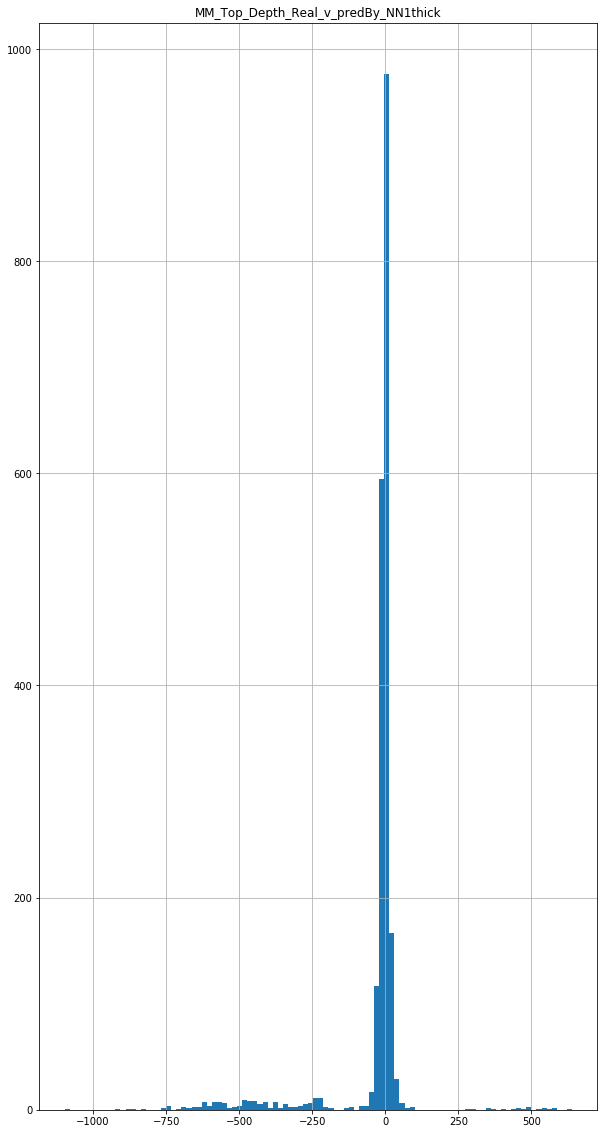

In [65]:
### Positive numbers are where real top is greater than predicted (200 vs. 100)
### Negative numbers are where real top is less than predicted top (0 vs. 500)
### Many negative numbers might be due to :
###    1) zeros & blanks being skipped in nearest neighbors and
###    2) not being skipped in 'real' tops 
doNotSaveThisDF_temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(10,20))

## The really high negative values might be from wells that don't have a base pick ? 0 - thickness in neighboring well where as the high positive numbers might be wells that have a base in neighboring well but not in well being predicting for?

### Let's investigate further by looking at the distribution of the thickness in nieghboring wells

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x794a8c056ba8>]],
      dtype=object)

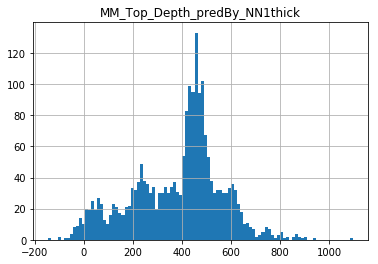

In [66]:
#MM_Top_Depth_Real_v_predBy_NN1thick
# temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100)
temp5.hist(column='MM_Top_Depth_predBy_NN1thick', bins=100)

- Most are around 430 with a big range that has shoulders around 200 and 600 thickness. 
- There are a few with less than zero? Are thosse were there was a base but not a top or the other way?

#### Let's check to see how many McMurray_Top_DEPTH and McMurray_Base_DEPTH are zeros

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x794a850f76a0>]],
      dtype=object)

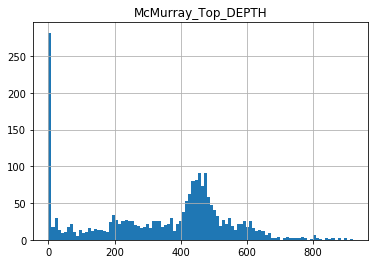

In [67]:
temp5.hist(column='McMurray_Top_DEPTH', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x794a85020da0>]],
      dtype=object)

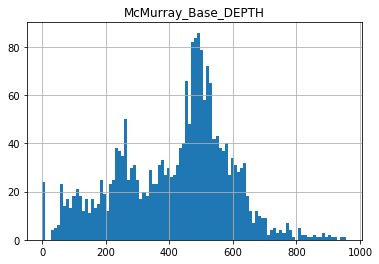

In [68]:
temp5.hist(column='McMurray_Base_DEPTH', bins=100)

### Let's investigate what is causing the problem above and find out where the zeros or missing values are

First, get absolute numbers intead of just a histogram

In [69]:
df_test = temp5.copy()

In [70]:
#### number of rows in each column with null values
df_test.isnull().sum()

SitID                            0
McMurray_Base_HorID              0
McMurray_Top_HorID               0
McMurray_Base_DEPTH              0
McMurray_Top_DEPTH               0
McMurray_Base_Qual               0
McMurray_Top_Qual                0
lat                              0
lng                              0
UWI                              0
Neighbors_Obj                    0
NN1_McMurray_Top_DEPTH          84
NN1_McMurray_Base_DEPTH          0
NN1_thickness                   84
MM_Top_Depth_predBy_NN1thick    84
dtype: int64

In [71]:
#### number of rows in each column with zero values
df_test[df_test.McMurray_Top_DEPTH == 0].count()

SitID                           247
McMurray_Base_HorID             247
McMurray_Top_HorID              247
McMurray_Base_DEPTH             247
McMurray_Top_DEPTH              247
McMurray_Base_Qual              247
McMurray_Top_Qual               247
lat                             247
lng                             247
UWI                             247
Neighbors_Obj                   247
NN1_McMurray_Top_DEPTH          168
NN1_McMurray_Base_DEPTH         247
NN1_thickness                   168
MM_Top_Depth_predBy_NN1thick    168
dtype: int64

#### Looks like both are issue but Top is bigger issue.

In [72]:
df_test[df_test.McMurray_Base_DEPTH == 0].count()

SitID                           24
McMurray_Base_HorID             24
McMurray_Top_HorID              24
McMurray_Base_DEPTH             24
McMurray_Top_DEPTH              24
McMurray_Base_Qual              24
McMurray_Top_Qual               24
lat                             24
lng                             24
UWI                             24
Neighbors_Obj                   24
NN1_McMurray_Top_DEPTH          24
NN1_McMurray_Base_DEPTH         24
NN1_thickness                   24
MM_Top_Depth_predBy_NN1thick    24
dtype: int64

### It appears there are 247 base McMurray picks with zero values and this is causing the problems
### Without a base, we can't add the nearest neighbor McMurray thickness to it and git a starting point to look for the top McMurray pick

### Below we will limit the dataset distribution to  only those wells that do have an interpreted McMurray base pick.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x794a84d90710>]],
      dtype=object)

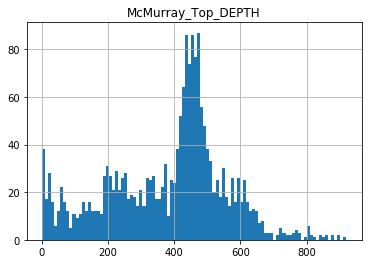

In [73]:
no_zeros_df = df_test[(df_test['McMurray_Base_DEPTH']!=0) & (df_test['McMurray_Top_DEPTH']!=0)]
no_zeros_df.hist(column='McMurray_Top_DEPTH', bins=100)

In [74]:
no_zeros_df['MM_Top_Depth_Real_v_predBy_NN1thick'] =  no_zeros_df['McMurray_Top_DEPTH'] - no_zeros_df['MM_Top_Depth_predBy_NN1thick'] 


/home/jgosses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x794a84d63a90>]],
      dtype=object)

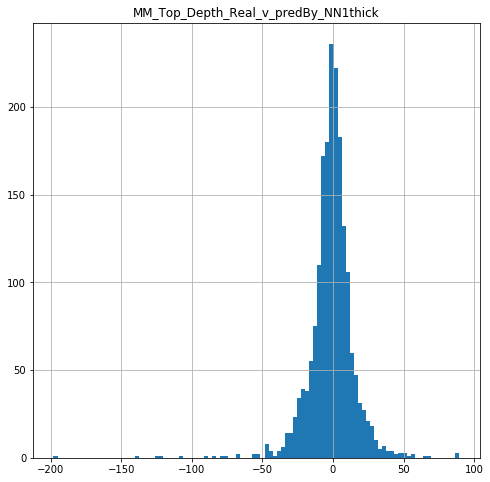

In [75]:
no_zeros_df.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(8,8))

In [76]:
len(no_zeros_df)

1926

### The histogram above seems more reasonable

Let's take out the column that might leak information about a wells top McMurray depth and then save this dataframe.

In [77]:
no_zeros_df_TopDepthVsNNleak = no_zeros_df.drop('MM_Top_Depth_Real_v_predBy_NN1thick', 1)

In [78]:
no_zeros_df_TopDepthVsNNleak

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness,MM_Top_Depth_predBy_NN1thick
0,102496,14000,13000,561.00,475.00,1,3,54.785907,-110.129320,00/12-08-067-01W4/0,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]",544.00,630.00,86.00,475.00
1,102497,14000,13000,604.50,515.00,1,3,54.782284,-110.269446,00/07-08-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145}]",529.00,613.00,84.00,520.50
2,102498,14000,13000,564.00,480.00,1,3,54.785892,-110.186851,00/09-11-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725}]",529.00,613.00,84.00,480.00
3,102500,14000,13000,636.50,549.00,1,3,54.829624,-110.269422,00/10-29-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.07898840474399109}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.08752301126560716}]",529.00,613.00,84.00,552.50
4,102501,14000,13000,613.00,529.00,1,2,54.840471,-110.224832,00/06-34-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.050134469469623355}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.055282561346227096}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.07715524006184091}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.09180352126144718}]",514.00,603.00,89.00,524.00
5,102503,14000,13000,553.50,488.50,1,2,54.771449,-110.402983,00/11-04-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.023989710460949984}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.058530785916471276}, {'neighbor': 3, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.06418817567901171}, {'neighbor': 4, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.08773076140100079}, 

In [79]:
#### dumping wells dataframe that has no zeros in NN depth to pickle file
pickle.dump(no_zeros_df_TopDepthVsNNleak, open( "wells_df__NB_KDtreePost062018_vA__NoMcTopLeak_v2.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

### Let's look at the results on a map

In [80]:
import os
import folium
print(folium.__version__)
import branca.colormap as cm
import os
import math
env = %env
pd.set_option('display.max_rows', 2000)

0.5.0


In [81]:
linear2 = cm.LinearColormap(
    ['#edf8b1','#7fcdbb','#2c7fb8','#273891'],
    vmin=-100, vmax=75
)

linear2


# linear3 = cm.LinearColormap(
#     ['darkblue','blue','lightblue','lightgreen','green','darkgreen'],
#      vmax=75,vmin=-100,
# )

# linear3

In [82]:
def depth_color(depth):
    if(math.isnan(depth)):
        print(" math.isnan(depth) => ", depth)
        return 'blue'
    else:
        depth = float(depth)
        if depth >= 50:
            color = '#3182bd'
        elif depth > 10 and depth < 50:
            color = '#9ecae1'
        elif depth > -10 and depth < 10:
            color = 'green'
        elif depth > -50 and depth < -10:
            color = '#ffeda0'
        elif depth > -150 and depth < -50:
            color = '#feb24c'
        elif depth > -300 and depth < -150:
            color = '#f03b20'
        else:
            color = 'blue'
    return color

In [83]:
def depth_color3(depth,colorMap):
    if(math.isnan(depth)):
        print("!!!!!!!!!!!!!!!!!!!!  ' '  or nan is in depth => ", depth)
        color = '#000000'
    else:
        depth = float(depth)
        print("depth in colormap 3",depth)
        color = colorMap(depth)
        
    print("color = ",color)    
    return color

In [84]:
center2 = [54.840471, -110.269399]
zoom2 = 6
m5 = folium.Map(center2, tiles='Stamen Toner', zoom_start=zoom2)

In [85]:


list_df_for_map = no_zeros_df.values.tolist()

for row in list_df_for_map[0:]:
    print("location = ",row[7:9]," and depth is",row[15:16][0], " and UWI is ",row[9:10][0])
    folium.CircleMarker(
    location=row[7:9],
    radius=2,
    color=depth_color(row[15:16][0]),
    fill=True,
#     popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
#     popup=folium.Popup(str(row[9:10][0]+ ", depth Top McMurray="+str(row[15:16][0])), parse_html=True)
    ).add_to(m5)

location =  [54.785906999999995, -110.12931999999999]  and depth is 0.0  and UWI is  00/12-08-067-01W4/0
location =  [54.782284, -110.269446]  and depth is -5.5  and UWI is  00/07-08-067-02W4/0
location =  [54.785892000000004, -110.186851]  and depth is 0.0  and UWI is  00/09-11-067-02W4/0
location =  [54.829624, -110.26942199999999]  and depth is -3.5  and UWI is  00/10-29-067-02W4/0
location =  [54.840470999999994, -110.224832]  and depth is 5.0  and UWI is  00/06-34-067-02W4/0
location =  [54.771449, -110.402983]  and depth is -0.5  and UWI is  00/11-04-067-03W4/0
location =  [54.785901, -110.42213100000001]  and depth is -6.5  and UWI is  00/10-08-067-03W4/0
location =  [54.800532999999994, -110.34576200000001]  and depth is 11.5  and UWI is  00/10-14-067-03W4/0
location =  [54.829632999999994, -110.396621]  and depth is 6.5  and UWI is  00/10-28-067-03W4/0
location =  [54.840441000000006, -110.320301]  and depth is -25.5  and UWI is  00/07-36-067-03W4/0
location =  [54.771451, -11

location =  [54.873029, -111.851923]  and depth is 3.3600000000000136  and UWI is  00/11-12-068-13W4/0
location =  [54.916755, -111.89666100000001]  and depth is -0.2999999999999545  and UWI is  00/10-27-068-13W4/0
location =  [54.92759, -111.89663700000001]  and depth is 0.910000000000025  and UWI is  00/07-34-068-13W4/0
location =  [54.916751, -112.00455600000001]  and depth is 3.0500000000000114  and UWI is  00/11-25-068-14W4/0
location =  [54.92759399999999, -112.049124]  and depth is -31.69999999999999  and UWI is  00/07-34-068-14W4/0
location =  [54.931203000000004, -112.284175]  and depth is 9.759999999999991  and UWI is  00/11-31-068-15W4/0
location =  [54.858266, -112.309458]  and depth is -120.7000000000001  and UWI is  00/11-01-068-16W4/0
location =  [54.872958999999994, -112.58929199999999]  and depth is -8.229999999999905  and UWI is  00/11-07-068-17W4/0
location =  [54.887595, -112.59553500000001]  and depth is -3.6899999999999977  and UWI is  00/12-18-068-17W4/0
location

location =  [55.043803000000004, -111.87756599999999]  and depth is 6.0  and UWI is  00/06-11-070-13W4/0
location =  [55.072952, -111.909252]  and depth is -7.0  and UWI is  00/05-22-070-13W4/0
location =  [55.087517000000005, -111.877633]  and depth is -6.0  and UWI is  00/06-26-070-13W4/0
location =  [55.102132999999995, -112.125386]  and depth is -6.6200000000000045  and UWI is  00/07-31-070-14W4/0
location =  [55.102141, -112.112443]  and depth is 3.0  and UWI is  00/05-32-070-14W4/0
location =  [55.033105000000006, -112.28421499999999]  and depth is 13.5  and UWI is  00/11-06-070-15W4/0
location =  [55.058615, -112.25256599999999]  and depth is -13.5  and UWI is  00/07-17-070-15W4/0
location =  [55.069453, -112.258853]  and depth is -4.0  and UWI is  00/03-20-070-15W4/0
location =  [55.109595, -112.22083400000001]  and depth is -7.240000000000066  and UWI is  00/16-33-070-15W4/0
location =  [55.043944999999994, -112.41141499999999]  and depth is -39.20999999999998  and UWI is  00/

location =  [55.117230000000006, -113.84310900000001]  and depth is -7.330000000000041  and UWI is  00/06-06-071-25W4/0
location =  [55.150045999999996, -113.83671899999999]  and depth is -3.3600000000001273  and UWI is  00/10-18-071-25W4/0
location =  [55.160885, -113.791758]  and depth is 88.38000000000011  and UWI is  00/06-21-071-25W4/0
location =  [55.179118, -113.73413500000001]  and depth is -19.510000000000105  and UWI is  00/10-26-071-25W4/0
location =  [55.135681999999996, -113.939148]  and depth is 1.2100000000000364  and UWI is  00/10-09-071-26W4/0
location =  [55.150234, -113.91351999999999]  and depth is -1.1399999999999864  and UWI is  00/10-15-071-26W4/0
location =  [55.150346, -113.945485]  and depth is 1.1399999999999864  and UWI is  00/11-16-071-26W4/0
location =  [55.161345999999995, -113.990523]  and depth is -4.259999999999991  and UWI is  00/07-19-071-26W4/0
location =  [55.121506000000004, -114.069445]  and depth is -8.57000000000005  and UWI is  00/11-03-071-01

location =  [55.222729, -112.94555]  and depth is -3.3500000000000227  and UWI is  00/11-12-072-20W4/0
location =  [55.28091800000001, -112.971153]  and depth is -14.519999999999982  and UWI is  00/11-35-072-20W4/0
location =  [55.255430000000004, -113.19555700000001]  and depth is -2.0  and UWI is  00/15-20-072-21W4/0
location =  [55.208231000000005, -113.40068799999999]  and depth is -14.92999999999995  and UWI is  00/10-01-072-23W4/0
location =  [55.219065, -113.407036]  and depth is 7.280000000000086  and UWI is  00/06-12-072-23W4/0
location =  [55.25539200000001, -113.496955]  and depth is -0.6299999999999955  and UWI is  00/16-20-072-23W4/0
location =  [55.280878, -113.477655]  and depth is 1.8000000000000682  and UWI is  00/10-33-072-23W4/0
location =  [55.208211999999996, -113.554585]  and depth is 0.0  and UWI is  00/10-01-072-24W4/0
location =  [55.219079, -113.65712099999999]  and depth is 9.149999999999977  and UWI is  00/07-08-072-24W4/0
location =  [55.262787, -113.682782

location =  [55.353664, -113.67649499999999]  and depth is 4.329999999999927  and UWI is  00/09-30-073-24W4/0
location =  [55.309937, -113.75336999999999]  and depth is -8.5  and UWI is  00/09-10-073-25W4/0
location =  [55.31354, -113.702097]  and depth is -18.5  and UWI is  00/16-12-073-25W4/0
location =  [55.346426, -113.72103100000001]  and depth is 8.68999999999994  and UWI is  00/04-25-073-25W4/0
location =  [55.321037, -113.88156299999999]  and depth is 8.240000000000009  and UWI is  00/08-14-073-26W4/0
location =  [55.368239, -113.89422900000001]  and depth is 27.730000000000018  and UWI is  00/11-35-073-26W4/0
location =  [55.295938, -114.114231]  and depth is 43.940000000000055  and UWI is  00/10-05-073-01W5/0
location =  [55.310387, -114.114225]  and depth is 15.409999999999968  and UWI is  00/10-08-073-01W5/0
location =  [55.32864, -114.056601]  and depth is -4.100000000000023  and UWI is  00/16-15-073-01W5/0
location =  [55.295937, -114.22309299999999]  and depth is 15.0  a

location =  [55.52817099999999, -110.66231499999999]  and depth is -11.5  and UWI is  00/10-26-075-05W4/0
location =  [55.470017000000006, -110.875753]  and depth is 41.0  and UWI is  00/11-04-075-06W4/0
location =  [55.480858, -110.86936200000001]  and depth is 27.5  and UWI is  00/07-09-075-06W4/0
location =  [55.499106000000005, -110.86936200000001]  and depth is -41.0  and UWI is  00/10-16-075-06W4/0
location =  [55.539013, -110.79811299999999]  and depth is 3.0  and UWI is  00/06-36-075-06W4/0
location =  [55.470020999999996, -111.024654]  and depth is -2.750000000000057  and UWI is  00/10-04-075-07W4/0
location =  [55.495475, -110.94700800000001]  and depth is 10.0  and UWI is  00/07-13-075-07W4/0
location =  [55.509944, -110.979281]  and depth is -13.720000000000027  and UWI is  00/06-23-075-07W4/0
location =  [55.542649, -110.998772]  and depth is -5.039999999999964  and UWI is  00/10-34-075-07W4/0
location =  [55.48445600000001, -111.21226499999999]  and depth is -4.1499999999

location =  [55.586346, -111.42559299999999]  and depth is 18.5  and UWI is  00/12-13-076-10W4/0
location =  [55.582738, -111.522724]  and depth is -4.930000000000007  and UWI is  00/06-17-076-10W4/0
location =  [55.626266, -111.40649499999999]  and depth is -9.0  and UWI is  00/08-36-076-10W4/0
location =  [55.58274599999999, -111.67156299999999]  and depth is -4.8799999999999955  and UWI is  00/07-17-076-11W4/0
location =  [55.615448, -111.61981499999999]  and depth is 0.5500000000000114  and UWI is  00/10-27-076-11W4/0
location =  [55.626264, -111.568071]  and depth is 4.8799999999999955  and UWI is  00/07-36-076-11W4/0
location =  [55.568117, -111.826799]  and depth is -0.32999999999992724  and UWI is  00/07-08-076-12W4/0
location =  [55.611837, -111.74918000000001]  and depth is -12.480000000000018  and UWI is  00/07-26-076-12W4/0
location =  [55.626276000000004, -111.85906000000001]  and depth is -12.789999999999907  and UWI is  00/06-31-076-12W4/0
location =  [55.629903000000006

location =  [55.640889, -113.560552]  and depth is 0.5299999999999727  and UWI is  00/07-06-077-23W4/0
location =  [55.688042, -113.45702]  and depth is 6.389999999999986  and UWI is  00/10-23-077-23W4/0
location =  [55.702684999999995, -113.489299]  and depth is -36.289999999999964  and UWI is  00/11-27-077-23W4/0
location =  [55.644503, -113.592831]  and depth is 25.600000000000136  and UWI is  00/11-01-077-24W4/0
location =  [55.699059, -113.58643799999999]  and depth is -44.190000000000055  and UWI is  00/07-25-077-24W4/0
location =  [55.702693000000004, -113.689968]  and depth is -7.680000000000064  and UWI is  00/10-29-077-24W4/0
location =  [55.71715, -113.638203]  and depth is 33.889999999999986  and UWI is  00/10-34-077-24W4/0
location =  [55.669986, -113.851623]  and depth is 5.17999999999995  and UWI is  00/06-17-077-25W4/0
location =  [55.68444100000001, -113.773996]  and depth is -13.620000000000005  and UWI is  AA/06-23-077-25W4/0
location =  [55.702674, -113.877496999999

location =  [55.782743, -113.57325700000001]  and depth is 4.5  and UWI is  00/04-30-078-23W4/0
location =  [55.804375, -113.48290800000001]  and depth is -13.099999999999966  and UWI is  00/10-34-078-23W4/0
location =  [55.757256000000005, -113.62502099999999]  and depth is -10.0  and UWI is  AA/05-14-078-24W4/0
location =  [55.775303, -113.71583600000001]  and depth is 1.5199999999999818  and UWI is  00/10-19-078-24W4/0
location =  [55.775319999999994, -113.68996000000001]  and depth is -1.2200000000000273  and UWI is  00/10-20-078-24W4/0
location =  [55.728148, -113.87749699999999]  and depth is -30.470000000000027  and UWI is  AA/06-06-078-25W4/0
location =  [55.77530600000001, -113.87110700000001]  and depth is -15.009999999999991  and UWI is  00/10-19-078-25W4/0
location =  [55.78631899999999, -113.748099]  and depth is -1.5199999999999818  and UWI is  00/06-25-078-25W4/0
location =  [55.800793999999996, -113.79985500000001]  and depth is 24.099999999999966  and UWI is  00/06-34-

location =  [55.869877, -113.50656000000001]  and depth is -6.229999999999961  and UWI is  00/01-27-079-23W4/0
location =  [55.815324, -113.61742199999999]  and depth is 5.5  and UWI is  00/07-01-079-24W4/0
location =  [55.818934, -113.747925]  and depth is -26.0  and UWI is  00/10-06-079-24W4/0
location =  [55.844409, -113.695714]  and depth is 13.109999999999957  and UWI is  00/07-16-079-24W4/0
location =  [55.818968000000005, -113.85233799999999]  and depth is -10.990000000000009  and UWI is  00/10-04-079-25W4/0
location =  [55.833403000000004, -113.78048000000001]  and depth is -0.5  and UWI is  00/11-12-079-25W4/0
location =  [55.858879, -113.80658400000002]  and depth is 22.5  and UWI is  00/06-23-079-25W4/0
location =  [55.88796899999999, -113.852322]  and depth is -0.9599999999999795  and UWI is  AA/07-33-079-25W4/0
location =  [55.87368000000001, -113.956702]  and depth is -8.54000000000002  and UWI is  00/07-26-079-26W4/0
location =  [55.81940600000001, -114.011729]  and dept

location =  [56.051680000000005, -112.15570100000001]  and depth is 1.5  and UWI is  AA/10-29-081-14W4/0
location =  [56.066128000000006, -112.234008]  and depth is -4.0  and UWI is  00/10-35-081-15W4/0
location =  [55.993506000000004, -112.416723]  and depth is -5.5  and UWI is  00/10-03-081-16W4/0
location =  [56.051669999999994, -112.390571]  and depth is -79.88  and UWI is  00/10-26-081-16W4/0
location =  [56.004325, -112.625532]  and depth is -2.530000000000001  and UWI is  00/07-08-081-17W4/0
location =  [56.022564, -112.547273]  and depth is 33.43999999999994  and UWI is  00/10-14-081-17W4/0
location =  [56.051639, -112.52765]  and depth is 1.2200000000000841  and UWI is  00/11-25-081-17W4/0
location =  [56.004332999999995, -112.782154]  and depth is -5.7900000000000205  and UWI is  00/07-08-081-18W4/0
location =  [56.007939, -112.684206]  and depth is 57.349999999999966  and UWI is  00/11-12-081-18W4/0
location =  [56.022579, -112.886559]  and depth is 7.239999999999952  and UW

location =  [56.124313, -111.97299]  and depth is 2.5  and UWI is  00/10-21-082-13W4/0
location =  [56.138940000000005, -111.999098]  and depth is -4.840000000000032  and UWI is  00/10-29-082-13W4/0
location =  [56.080757, -112.181804]  and depth is 2.0  and UWI is  00/10-06-082-14W4/0
location =  [56.10985600000001, -112.129601]  and depth is -6.0  and UWI is  00/10-16-082-14W4/0
location =  [56.135328, -112.109945]  and depth is 3.3700000000000045  and UWI is  00/06-27-082-14W4/0
location =  [56.09521899999999, -112.312257]  and depth is -0.5  and UWI is  00/10-08-082-15W4/0
location =  [56.135313000000004, -112.214352]  and depth is 4.0  and UWI is  00/06-25-082-15W4/0
location =  [56.149749, -112.47538]  and depth is -2.4399999999999977  and UWI is  00/06-32-082-16W4/0
location =  [56.149768, -112.42309099999999]  and depth is 0.6099999999999568  and UWI is  00/06-34-082-16W4/0
location =  [56.149765, -112.370801]  and depth is -6.399999999999977  and UWI is  00/06-36-082-16W4/0
lo

location =  [56.328062, -110.67416000000001]  and depth is -84.0  and UWI is  00/10-35-084-05W4/0
location =  [56.251822, -110.917774]  and depth is 7.0  and UWI is  00/06-05-084-06W4/0
location =  [56.298961, -110.81241399999999]  and depth is 16.5  and UWI is  00/11-24-084-06W4/0
location =  [56.313614, -110.91128799999998]  and depth is 68.30000000000001  and UWI is  00/10-29-084-06W4/0
location =  [56.328065, -110.91779199999999]  and depth is -24.80000000000001  and UWI is  AB/11-32-084-06W4/0
location =  [56.284543000000006, -111.023154]  and depth is -32.89999999999998  and UWI is  AA/11-15-084-07W4/0
location =  [56.284539, -111.075837]  and depth is 17.399999999999977  and UWI is  AA/11-17-084-07W4/0
location =  [56.313628, -111.06282900000001]  and depth is -6.639999999999986  and UWI is  AA/09-29-084-07W4/0
location =  [56.269901000000004, -111.260172]  and depth is -4.689999999999998  and UWI is  AA/11-07-084-08W4/0
location =  [56.269911, -111.240261]  and depth is 3.36000

location =  [56.462688, -112.623011]  and depth is 10.280000000000001  and UWI is  AA/15-16-086-17W4/0
location =  [56.48455500000001, -112.55065800000001]  and depth is -0.3900000000000148  and UWI is  AA/06-25-086-17W4/0
location =  [56.477097, -112.741243]  and depth is nan  and UWI is  00/13-23-086-18W4/0
 math.isnan(depth) =>  nan
location =  [56.48449300000001, -113.28148200000001]  and depth is 0.3100000000000023  and UWI is  00/07-29-086-21W4/0
location =  [56.426339, -113.433024]  and depth is -9.460000000000036  and UWI is  00/08-05-086-22W4/0
location =  [56.444402000000004, -113.439526]  and depth is -9.140000000000043  and UWI is  00/10-08-086-22W4/0
location =  [56.502545, -113.446027]  and depth is 9.140000000000043  and UWI is  00/11-32-086-22W4/0
location =  [56.498932999999994, -113.334167]  and depth is 9.75  and UWI is  00/07-36-086-22W4/0
location =  [56.444413, -113.51854399999999]  and depth is 3.3500000000000227  and UWI is  00/10-11-086-23W4/0
location =  [56.4

location =  [56.760698, -111.37099599999999]  and depth is 24.37999999999998  and UWI is  AA/07-33-089-09W4/0
location =  [56.76430500000001, -111.317854]  and depth is -25.909999999999997  and UWI is  AA/10-35-089-09W4/0
location =  [56.720738, -111.490559]  and depth is -13.849999999999994  and UWI is  AA/12-14-089-10W4/0
location =  [56.731573, -111.563675]  and depth is -9.0  and UWI is  AA/06-20-089-10W4/0
location =  [56.760678000000006, -111.48398799999998]  and depth is 35.5  and UWI is  AA/06-35-089-10W4/0
location =  [56.684449, -111.723184]  and depth is -11.27000000000001  and UWI is  AA/03-05-089-11W4/0
location =  [56.706117000000006, -111.7432]  and depth is -2.4399999999999977  and UWI is  AA/10-07-089-11W4/0
location =  [56.684442000000004, -111.796369]  and depth is 4.260000000000019  and UWI is  AA/02-02-089-12W4/0
location =  [56.717121, -111.9027]  and depth is 6.579999999999984  and UWI is  AA/07-18-089-12W4/0
location =  [56.749829000000005, -111.882671]  and dep

location =  [56.946364, -111.558226]  and depth is -8.659999999999997  and UWI is  AA/04-04-092-10W4/0
location =  [56.968038, -111.55154499999999]  and depth is -0.1599999999999966  and UWI is  AA/11-09-092-10W4/0
location =  [56.97545, -111.524732]  and depth is 8.66  and UWI is  AA/03-15-092-10W4/0
location =  [57.029842, -111.518125]  and depth is 11.840000000000003  and UWI is  AB/15-34-092-10W4/0
location =  [56.94641800000001, -111.745869]  and depth is 2.1400000000000006  and UWI is  AA/04-05-092-11W4/0
location =  [56.997122999999995, -111.766152]  and depth is 6.400000000000006  and UWI is  AA/11-19-092-11W4/0
location =  [56.989915, -111.665411]  and depth is 1.0  and UWI is  AB/04-23-092-11W4/0
location =  [57.00458100000001, -111.75290600000001]  and depth is 5.180000000000007  and UWI is  AA/01-30-092-11W4/0
location =  [56.946422, -111.887078]  and depth is -9.5  and UWI is  AA/01-05-092-12W4/0
location =  [56.975497999999995, -111.906879]  and depth is -4.0  and UWI is 

location =  [57.200697999999996, -112.46396499999999]  and depth is -4.0  and UWI is  00/11-35-094-16W4/0
location =  [57.197077, -112.437124]  and depth is -2.769999999999982  and UWI is  03/06-36-094-16W4/0
location =  [57.193451, -112.732386]  and depth is 13.5  and UWI is  00/03-31-094-17W4/0
location =  [57.167984, -112.765786]  and depth is 1.0  and UWI is  00/05-24-094-18W4/0
location =  [57.215472999999996, -110.856482]  and depth is -21.5  and UWI is  AA/10-02-095-06W4/0
location =  [57.229921999999995, -110.856481]  and depth is -18.0  and UWI is  AA/10-11-095-06W4/0
location =  [57.20821, -110.98517199999999]  and depth is -27.0  and UWI is  AA/01-01-095-07W4/0
location =  [57.237367000000006, -111.025622]  and depth is 6.5  and UWI is  00/03-14-095-07W4/0
location =  [57.258993999999994, -111.10686000000001]  and depth is -35.5  and UWI is  AA/11-20-095-07W4/0
location =  [57.280846999999994, -111.012245]  and depth is -2.0  and UWI is  AA/01-35-095-07W4/0
location =  [57.2

location =  [57.4481, -111.127246]  and depth is -23.0  and UWI is  AA/10-30-097-07W4/0
location =  [57.462561, -111.100167]  and depth is 32.0  and UWI is  AA/10-32-097-07W4/0
location =  [57.382728, -111.248855]  and depth is -22.5  and UWI is  AA/04-04-097-08W4/0
location =  [57.407998, -111.154326]  and depth is -14.5  and UWI is  AA/15-12-097-08W4/0
location =  [57.437079000000004, -111.154327]  and depth is 15.320000000000002  and UWI is  AA/15-24-097-08W4/0
location =  [57.40799499999999, -111.45885600000001]  and depth is 10.0  and UWI is  AA/14-07-097-09W4/0
location =  [57.4154, -111.458868]  and depth is -21.0  and UWI is  AA/06-18-097-09W4/0
location =  [57.444480000000006, -111.45891499999999]  and depth is 35.0  and UWI is  AA/06-30-097-09W4/0
location =  [57.389922, -111.628091]  and depth is 24.0  and UWI is  AA/12-06-097-10W4/0
location =  [57.411793, -111.60805500000001]  and depth is -15.5  and UWI is  AA/01-18-097-10W4/0
location =  [57.444492000000004, -111.5196790

In [86]:
m5

### In general it seems the variance is relatively evenly distributed. 
A lot of the map has green, which means the neighboring wells thickness + base results in a top prediction that is within plus or minues 10 feet. Where the difference is outside that range, it seems it isn't that much farther off most of the time. There might be some areas in NE and eastern margin where variance is larger than in central area.

In [87]:
m5.save(os.path.join('.', 'MM_Top_Depth_Real_v_predBy_NN1thick_v2.html'))

#### might try this d3.js block of leaflet.js for ideas on how to draw polygons over the map and then use those polygons as features.

https://bl.ocks.org/danswick/d30c44b081be31aea483

### Future work

In [83]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    
    
    return uwi_array, distance_array
    

In [84]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return uwi_nearest, uwi_array, nearest_TopM_depth, avg_TopM_depth, nearest_BaseM_depth, avg_BaseM_depth
    

In [85]:
#### 2. Return an array of pick depths at N neighbor wells within a certain maximum distance.
#### takes in array or pandas df? returns dataframe?
def arrayOfPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return array_of_depths
    

In [86]:
#### 3. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def avgDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return avg_of_depthsAbvBelow

In [87]:
#### 4. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def arrayDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return array_of_depthsAbvBelow